In [3]:
!pip install prophet


In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from prophet import Prophet


In [5]:
import pandas as pd

df = pd.read_csv("/Users/vibhutihardoneeya/Downloads/Walmart Data Analysis and Forcasting.csv")
df.head()


Store        Date  Weekly_Sales  Holiday_Flag  Temperature  Fuel_Price  \
0      1  05-02-2010    1643690.90             0        42.31       2.572   
1      1  12-02-2010    1641957.44             1        38.51       2.548   
2      1  19-02-2010    1611968.17             0        39.93       2.514   
3      1  26-02-2010    1409727.59             0        46.63       2.561   
4      1  05-03-2010    1554806.68             0        46.50       2.625   

          CPI  Unemployment  
0  211.096358         8.106  
1  211.242170         8.106  
2  211.289143         8.106  
3  211.319643         8.106  
4  211.350143         8.106

In [6]:
print(df.isnull().sum())


Store           0
Date            0
Weekly_Sales    0
Holiday_Flag    0
Temperature     0
Fuel_Price      0
CPI             0
Unemployment    0
dtype: int64


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         6435 non-null   int64  
 1   Date          6435 non-null   object 
 2   Weekly_Sales  6435 non-null   float64
 3   Holiday_Flag  6435 non-null   int64  
 4   Temperature   6435 non-null   float64
 5   Fuel_Price    6435 non-null   float64
 6   CPI           6435 non-null   float64
 7   Unemployment  6435 non-null   float64
dtypes: float64(5), int64(2), object(1)
memory usage: 402.3+ KB


In [8]:
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Store         6435 non-null   int64         
 1   Date          6435 non-null   datetime64[ns]
 2   Weekly_Sales  6435 non-null   float64       
 3   Holiday_Flag  6435 non-null   int64         
 4   Temperature   6435 non-null   float64       
 5   Fuel_Price    6435 non-null   float64       
 6   CPI           6435 non-null   float64       
 7   Unemployment  6435 non-null   float64       
dtypes: datetime64[ns](1), float64(5), int64(2)
memory usage: 402.3 KB


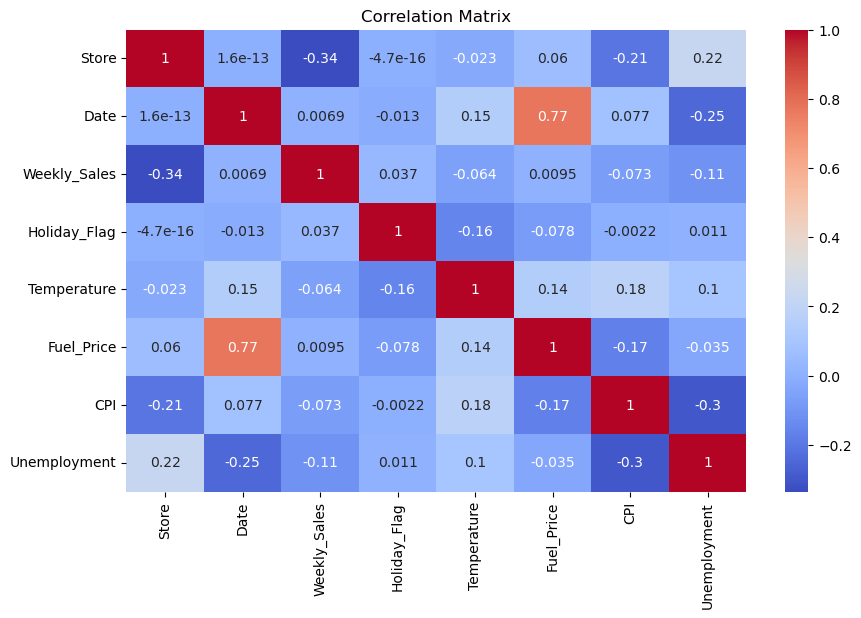

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()


In [10]:
from scipy.stats import zscore

z_scores = zscore(df[['Weekly_Sales', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment']])
outliers = (abs(z_scores) > 3)
df_no_outliers = df[(~outliers).all(axis=1)]


In [11]:
print(df.describe())


             Store                 Date  Weekly_Sales  Holiday_Flag  \
count  6435.000000                 6435  6.435000e+03   6435.000000   
mean     23.000000  2011-06-17 00:00:00  1.046965e+06      0.069930   
min       1.000000  2010-02-05 00:00:00  2.099862e+05      0.000000   
25%      12.000000  2010-10-08 00:00:00  5.533501e+05      0.000000   
50%      23.000000  2011-06-17 00:00:00  9.607460e+05      0.000000   
75%      34.000000  2012-02-24 00:00:00  1.420159e+06      0.000000   
max      45.000000  2012-10-26 00:00:00  3.818686e+06      1.000000   
std      12.988182                  NaN  5.643666e+05      0.255049   

       Temperature   Fuel_Price          CPI  Unemployment  
count  6435.000000  6435.000000  6435.000000   6435.000000  
mean     60.663782     3.358607   171.578394      7.999151  
min      -2.060000     2.472000   126.064000      3.879000  
25%      47.460000     2.933000   131.735000      6.891000  
50%      62.670000     3.445000   182.616521      7.874

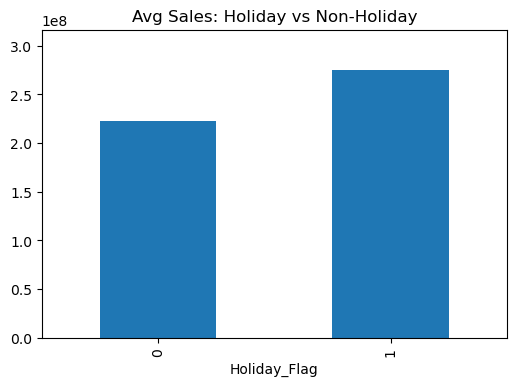

In [12]:
# Weekly Sales Trend
df.groupby('Date')['Weekly_Sales'].sum().plot(title="Total Weekly Sales Over Time", figsize=(12,4))

# Sales by Store
df.groupby('Store')['Weekly_Sales'].sum().plot(kind='bar', title="Total Sales by Store", figsize=(12,4))

# Sales on Holidays vs Non-Holidays
df.groupby('Holiday_Flag')['Weekly_Sales'].mean().plot(kind='bar', title="Avg Sales: Holiday vs Non-Holiday", figsize=(6,4))

plt.show()


In [13]:
store1 = df[df['Store'] == 1].sort_values('Date')
ts = store1[['Date', 'Weekly_Sales']].set_index('Date')


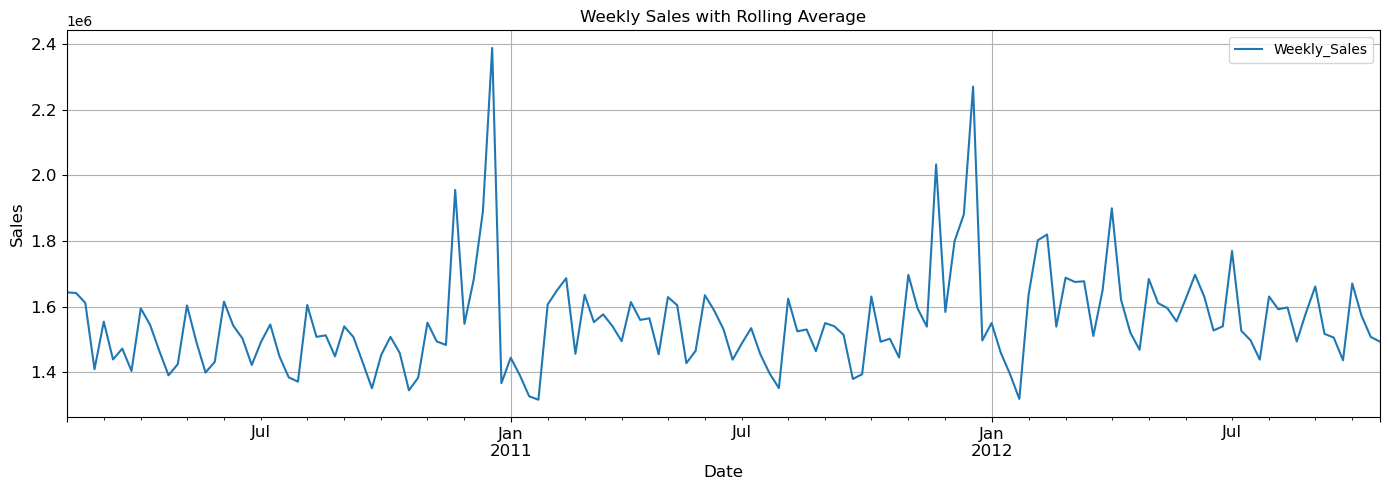

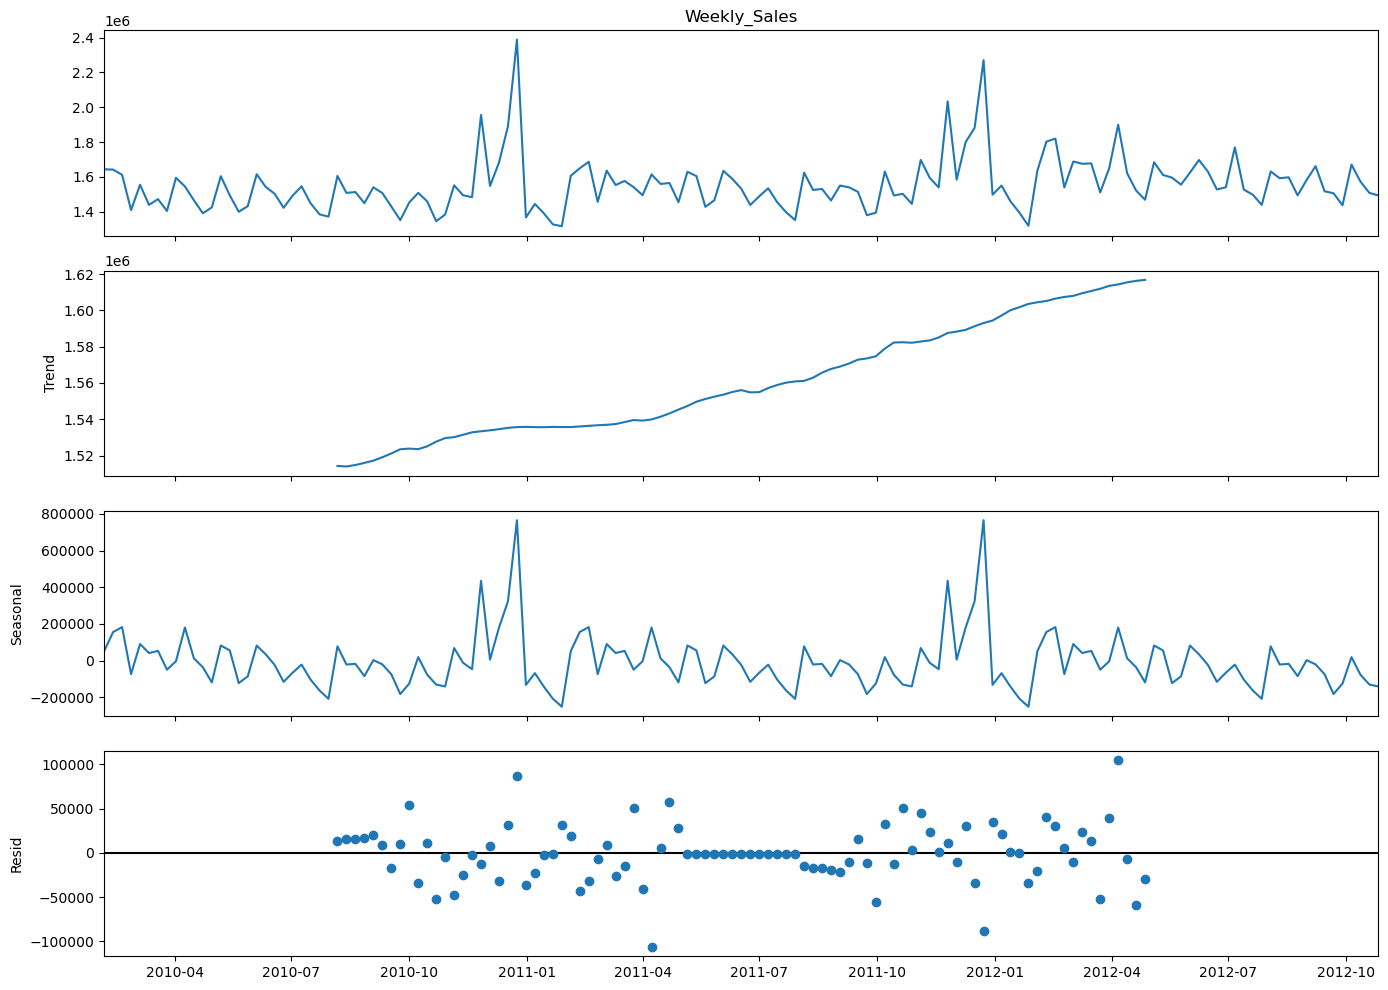

In [14]:
import statsmodels.api as sm
import matplotlib.pyplot as plt


# Plot rolling average with increased size
ts.plot(title="Weekly Sales with Rolling Average", figsize=(14, 5), fontsize=12)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Sales", fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

# Decomposition
decomp = sm.tsa.seasonal_decompose(ts['Weekly_Sales'], model='additive', period=52)
fig = decomp.plot()
fig.set_size_inches(14, 10)  # Set larger size for decomposition plot
plt.tight_layout()
plt.show()



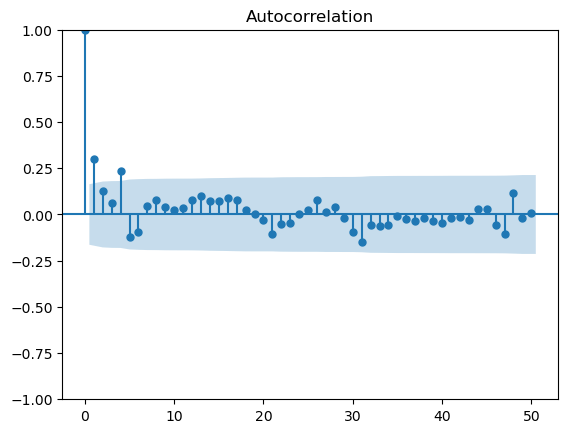

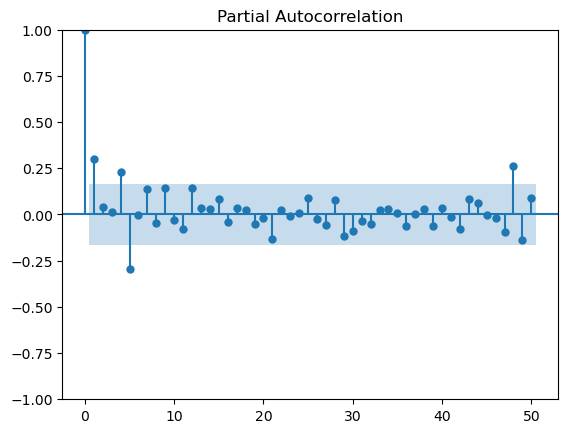

In [15]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts['Weekly_Sales'].dropna(), lags=50)
plot_pacf(ts['Weekly_Sales'].dropna(), lags=50)
plt.show()


22:34:18 - cmdstanpy - INFO - Chain [1] start processing
22:34:18 - cmdstanpy - INFO - Chain [1] done processing


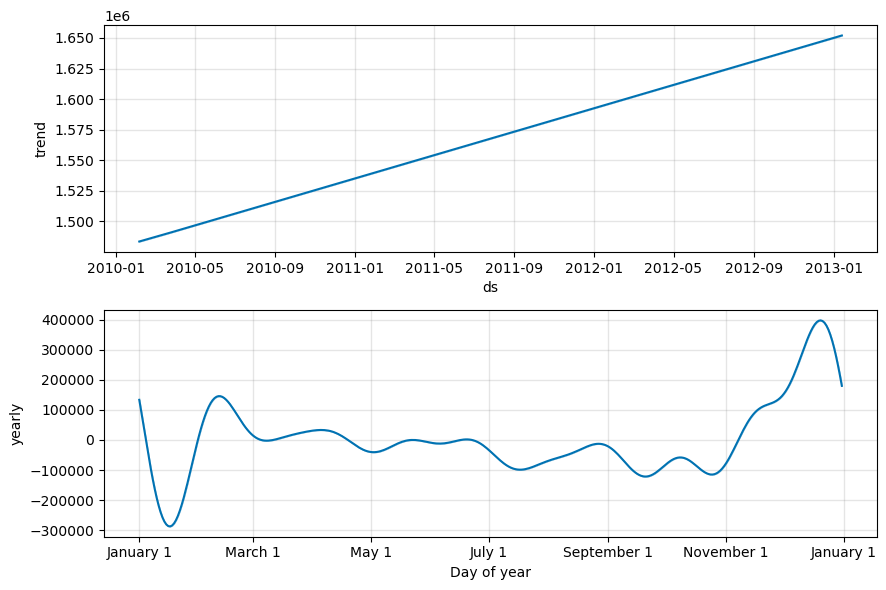

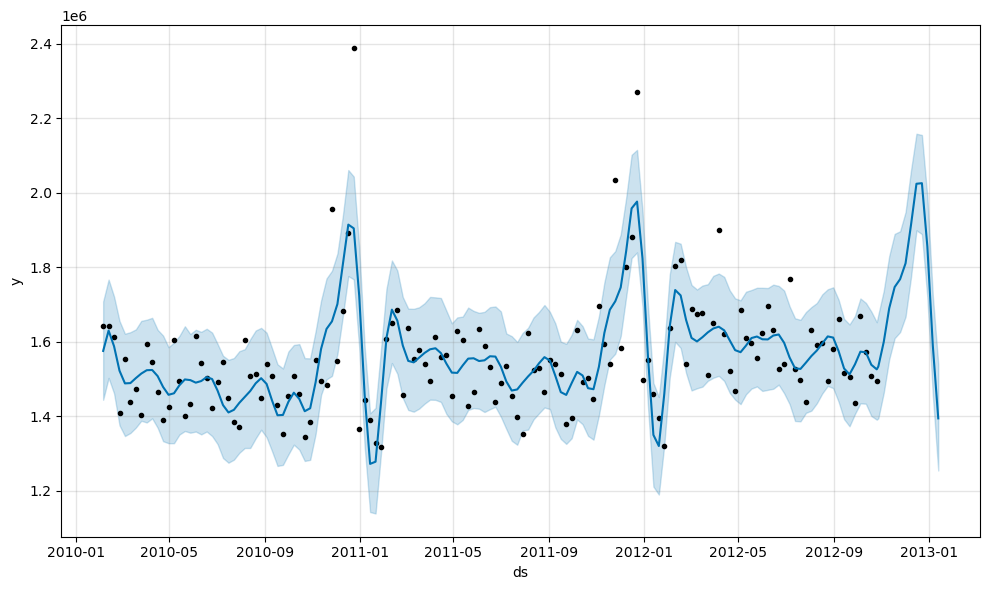

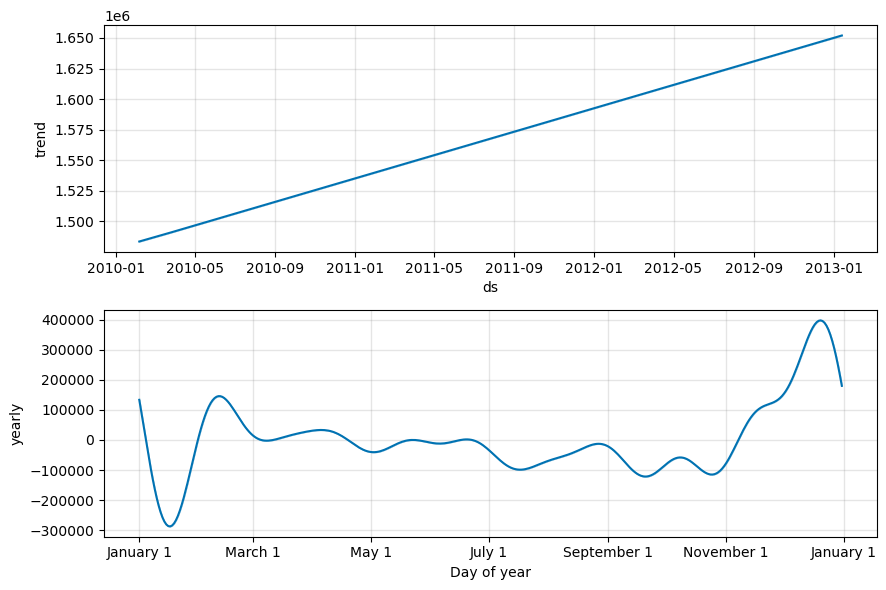

In [16]:
from prophet import Prophet

# Prepare data
df_prophet = store1[['Date', 'Weekly_Sales']].rename(columns={"Date": "ds", "Weekly_Sales": "y"})

# Model
model = Prophet()
model.fit(df_prophet)

# Make future predictions
future = model.make_future_dataframe(periods=12, freq='W')
forecast = model.predict(future)

# Plot
model.plot(forecast)
model.plot_components(forecast)


In [17]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Actual vs Predicted for Prophet
y_true = df_prophet['y'][-12:]
y_pred = forecast['yhat'][-12:]

rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae = mean_absolute_error(y_true, y_pred)

print("RMSE:", rmse)
print("MAE:", mae)

RMSE: 274030.5032818303
MAE: 219764.86546507315


In [18]:
from prophet.diagnostics import cross_validation, performance_metrics

# Cross-validation: simulate forecasts
df_cv = cross_validation(model, initial='400 days', period='90 days', horizon='90 days')

# Metrics
df_p = performance_metrics(df_cv)
print(df_p[['horizon', 'rmse', 'mae', 'mape']])


  0%|          | 0/6 [00:00<?, ?it/s]

22:34:25 - cmdstanpy - INFO - Chain [1] start processing
22:34:25 - cmdstanpy - INFO - Chain [1] done processing
22:34:25 - cmdstanpy - INFO - Chain [1] start processing
22:34:25 - cmdstanpy - INFO - Chain [1] done processing
22:34:25 - cmdstanpy - INFO - Chain [1] start processing
22:34:25 - cmdstanpy - INFO - Chain [1] done processing
22:34:25 - cmdstanpy - INFO - Chain [1] start processing
22:34:25 - cmdstanpy - INFO - Chain [1] done processing
22:34:25 - cmdstanpy - INFO - Chain [1] start processing
22:34:25 - cmdstanpy - INFO - Chain [1] done processing
22:34:25 - cmdstanpy - INFO - Chain [1] start processing
22:34:25 - cmdstanpy - INFO - Chain [1] done processing


   horizon           rmse            mae      mape
0   8 days  128683.338128  116698.218781  0.070671
1   9 days  118910.339277  100297.534194  0.060704
2  10 days  102431.216692   79665.336110  0.048028
3  11 days   78098.278147   65520.745003  0.039175
4  12 days   78276.945812   66032.894125  0.039527
..     ...            ...            ...       ...
67 86 days   83632.380046   69261.404829  0.048583
68 87 days   89413.596369   74191.389899  0.053432
69 88 days   88486.156045   73356.712253  0.052335
70 89 days   95457.812136   81054.696278  0.057987
71 90 days   96165.580028   83176.604310  0.059414

[72 rows x 4 columns]


/opt/anaconda3/lib/python3.12/site-packages/prophet/plot.py:547: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  x_plt = df_none['horizon'].astype('timedelta64[ns]').view(np.int64) / float(dt_conversions[i])
/opt/anaconda3/lib/python3.12/site-packages/prophet/plot.py:548: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  x_plt_h = df_h['horizon'].astype('timedelta64[ns]').view(np.int64) / float(dt_conversions[i])


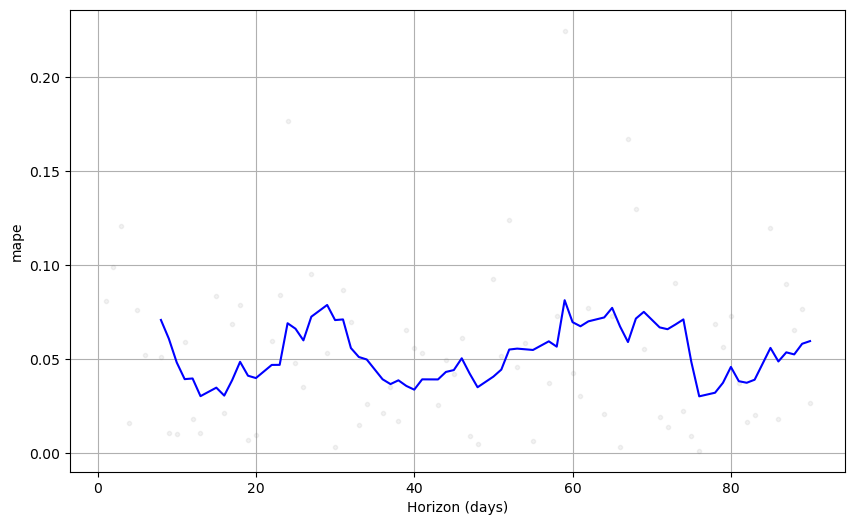

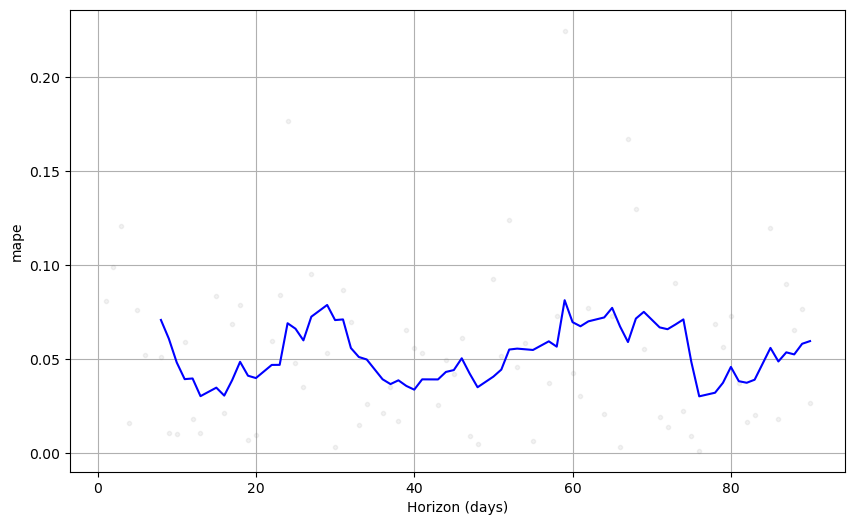

In [19]:
from prophet.plot import plot_cross_validation_metric
plot_cross_validation_metric(df_cv, metric='mape')


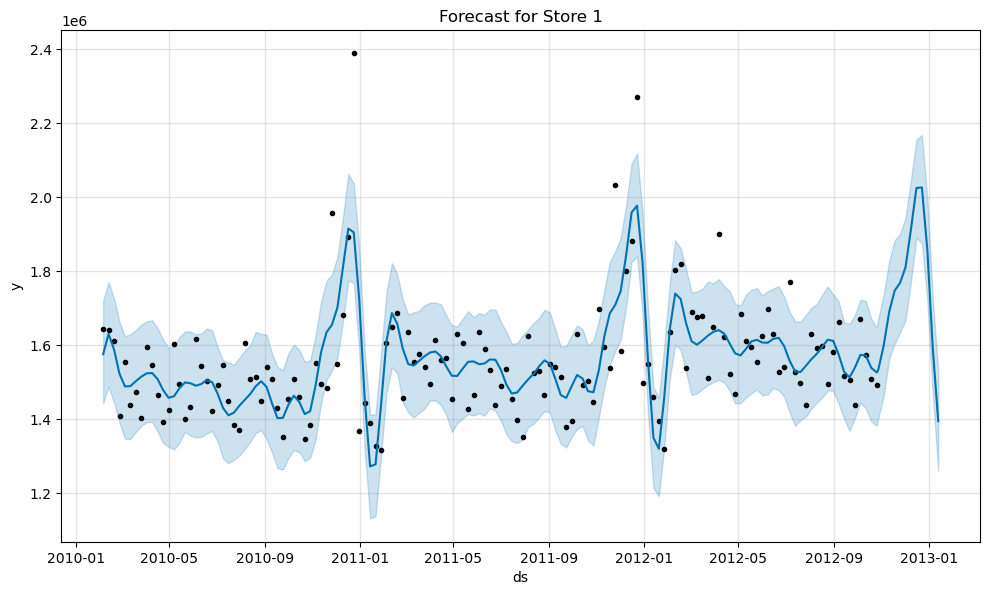

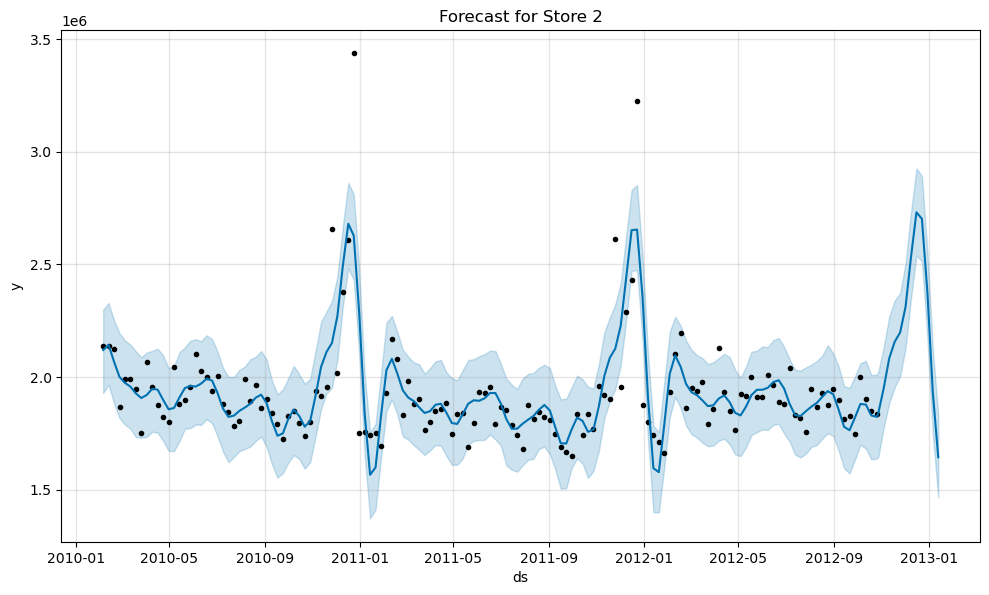

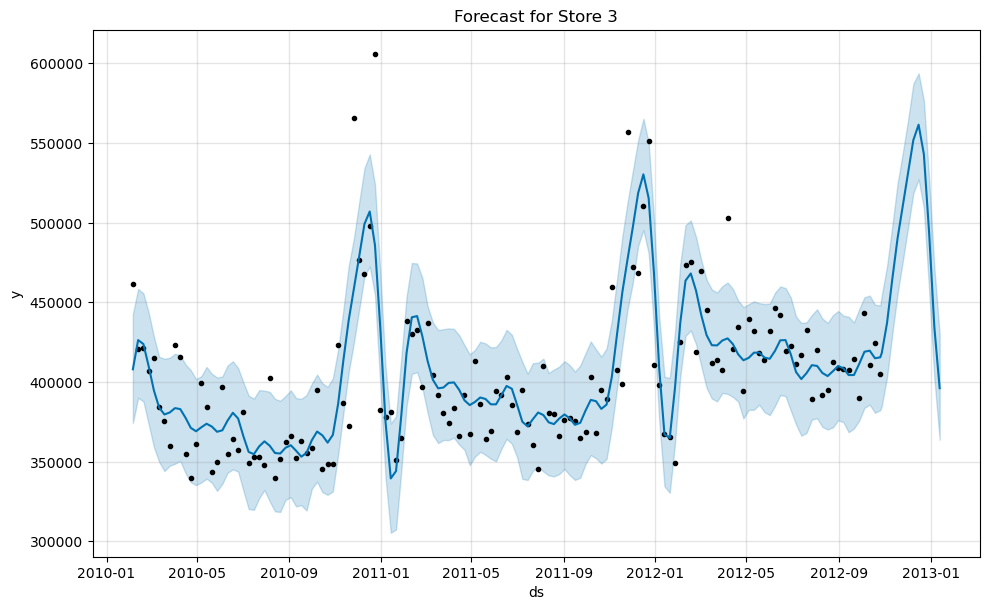

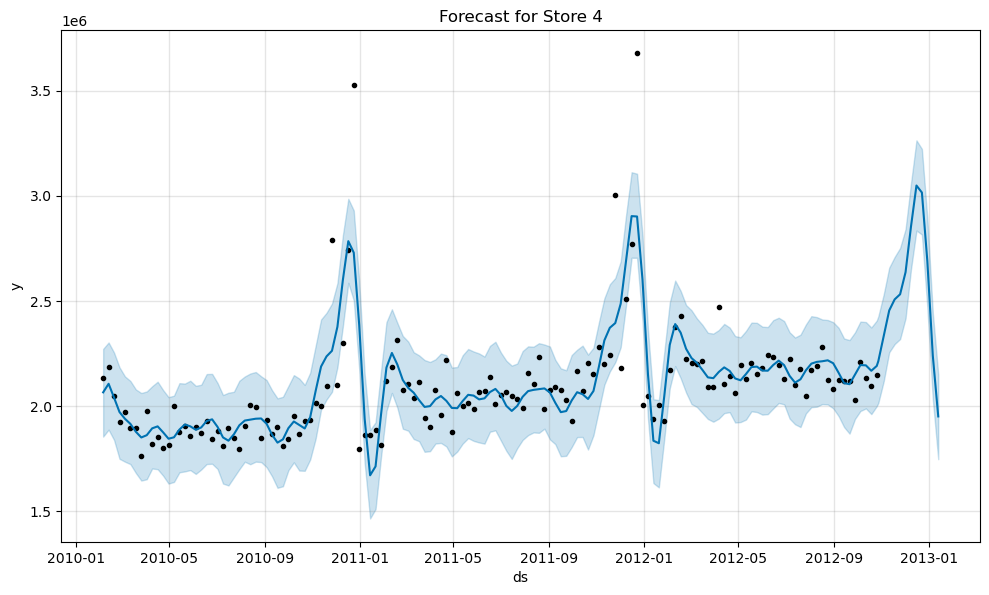

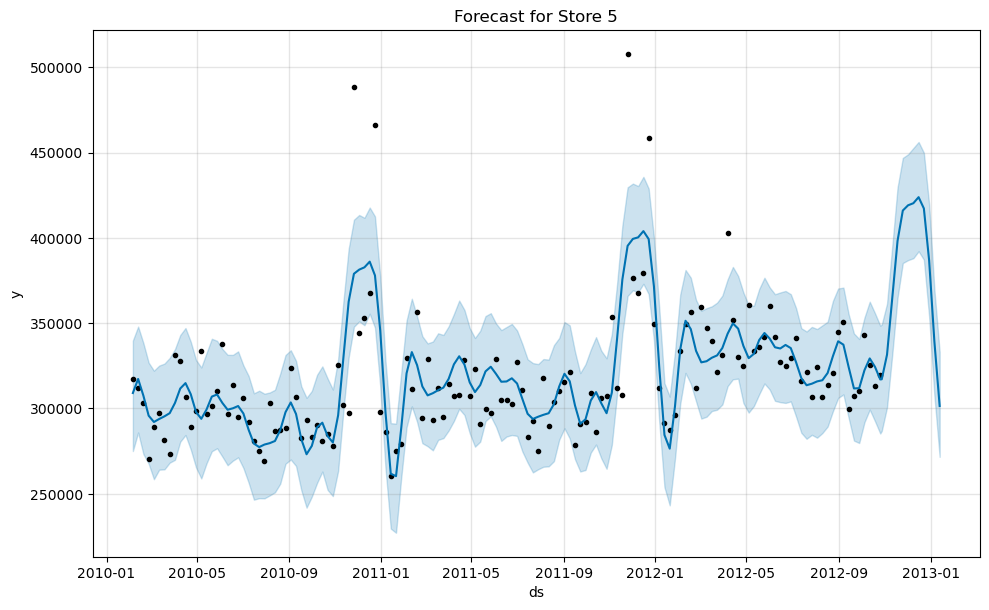

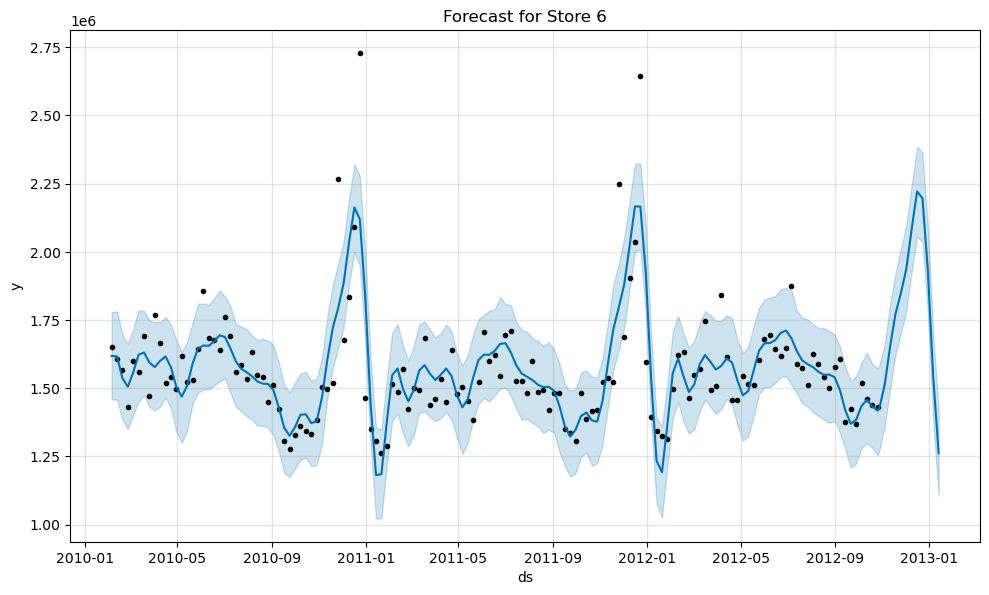

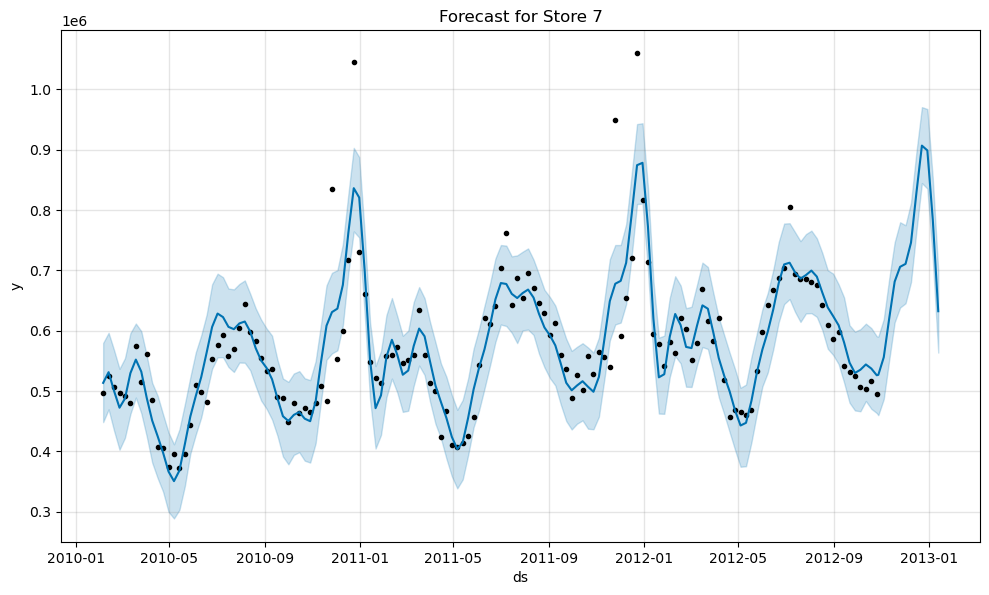

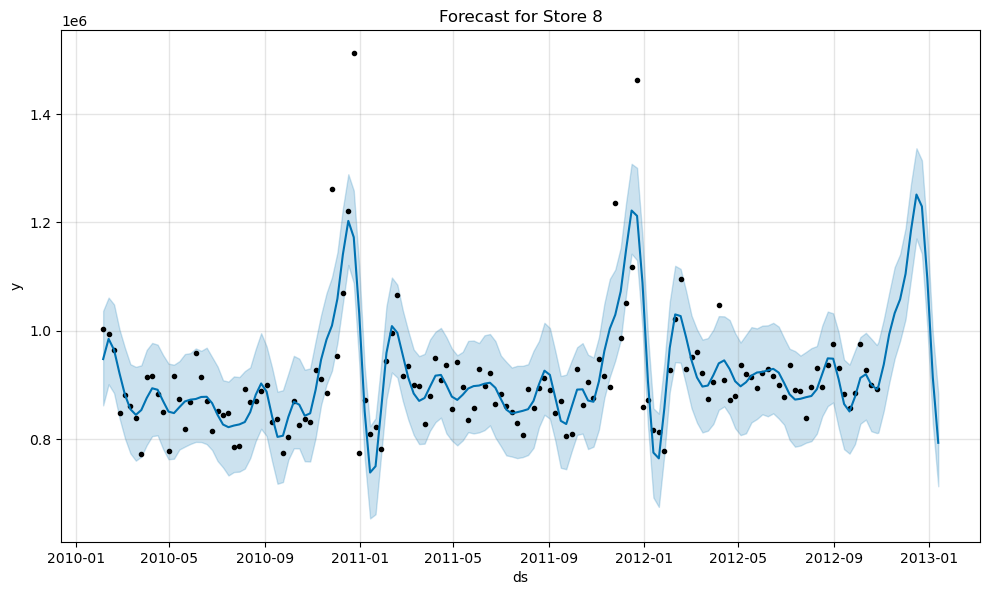

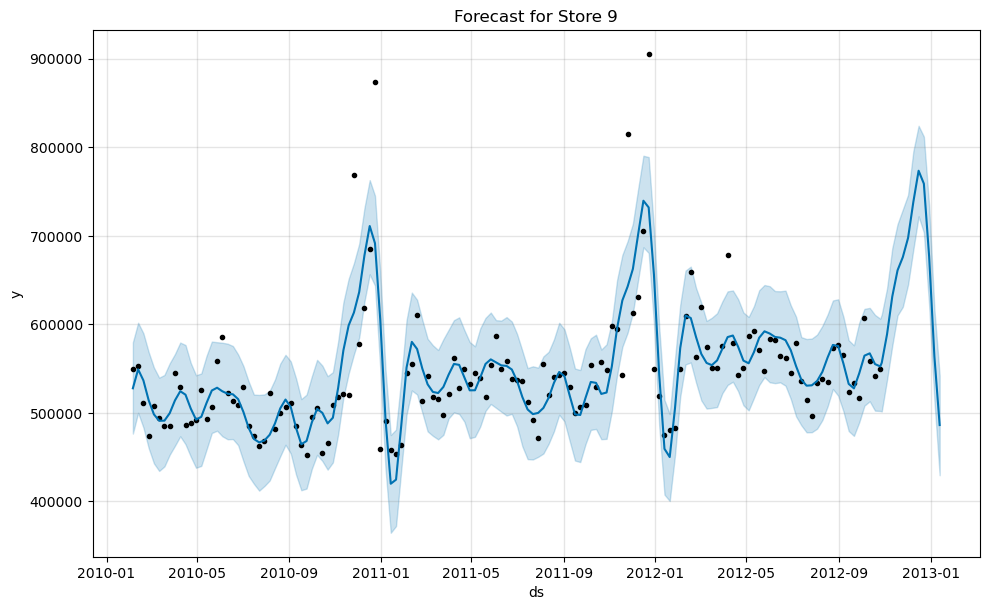

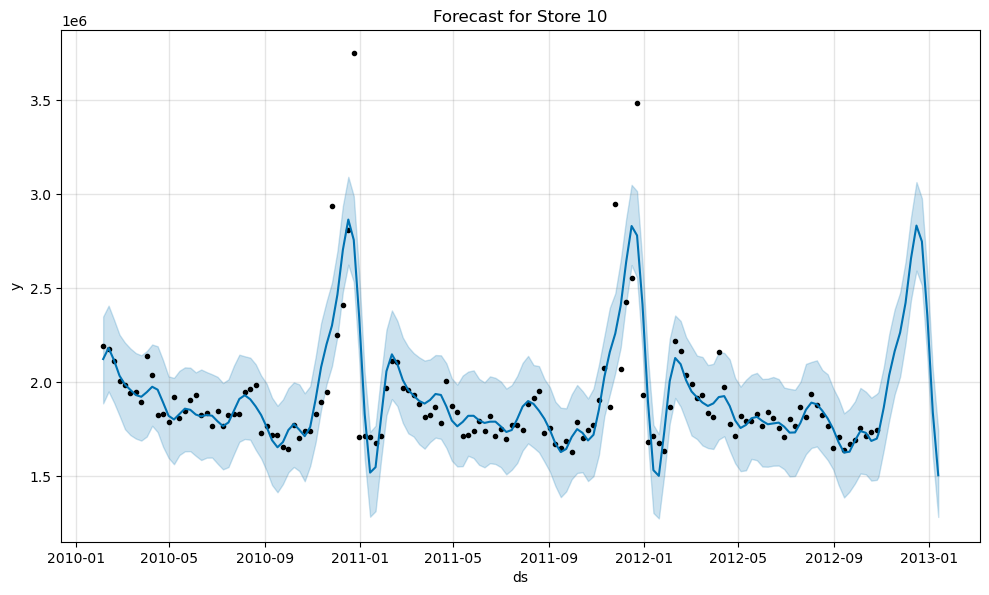

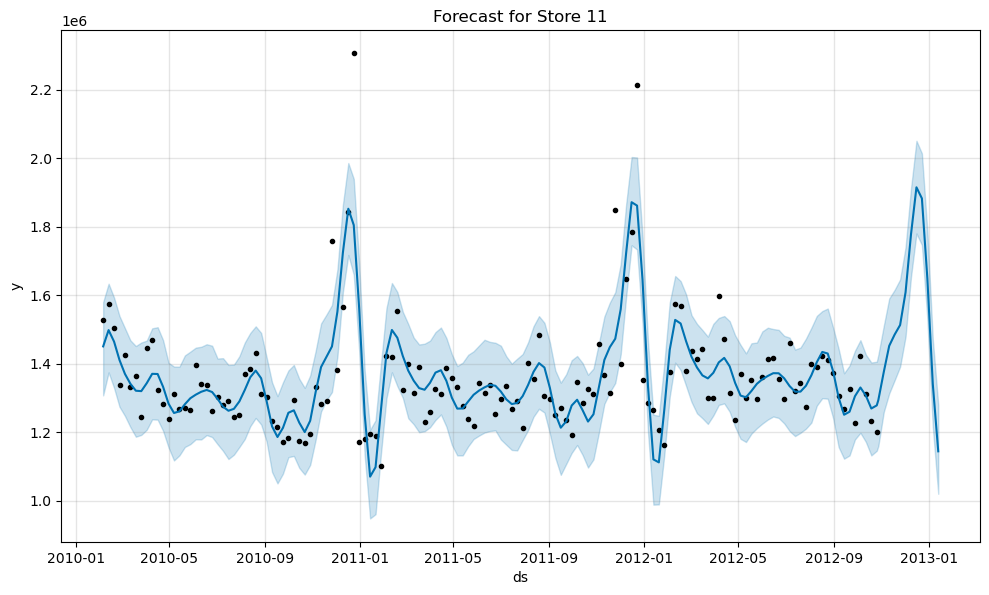

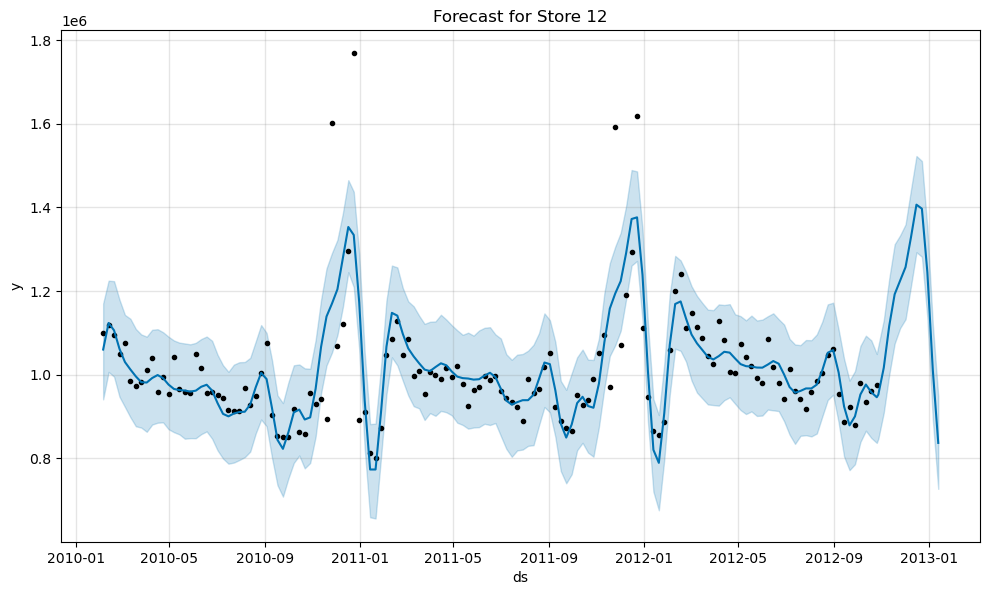

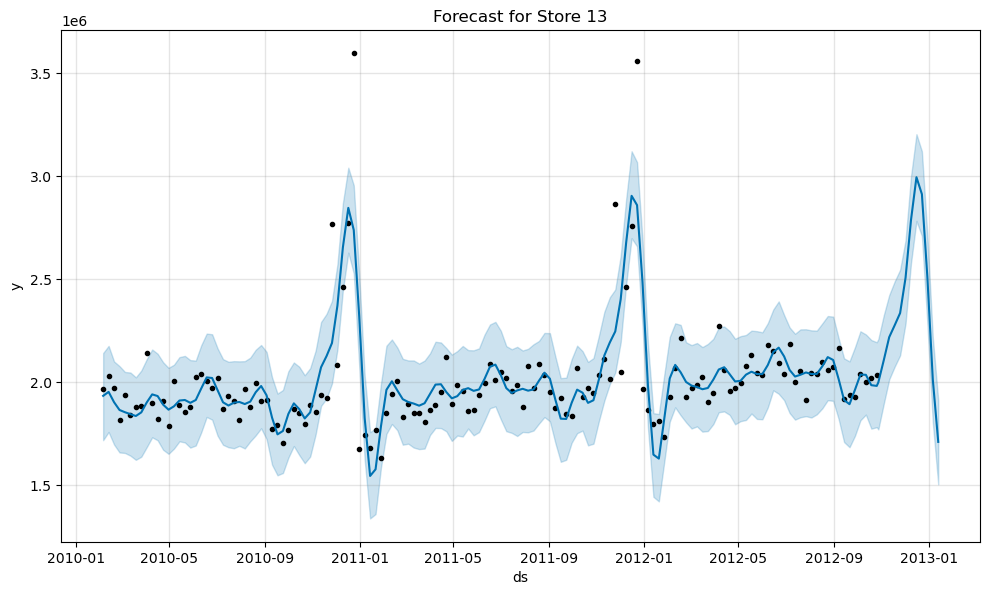

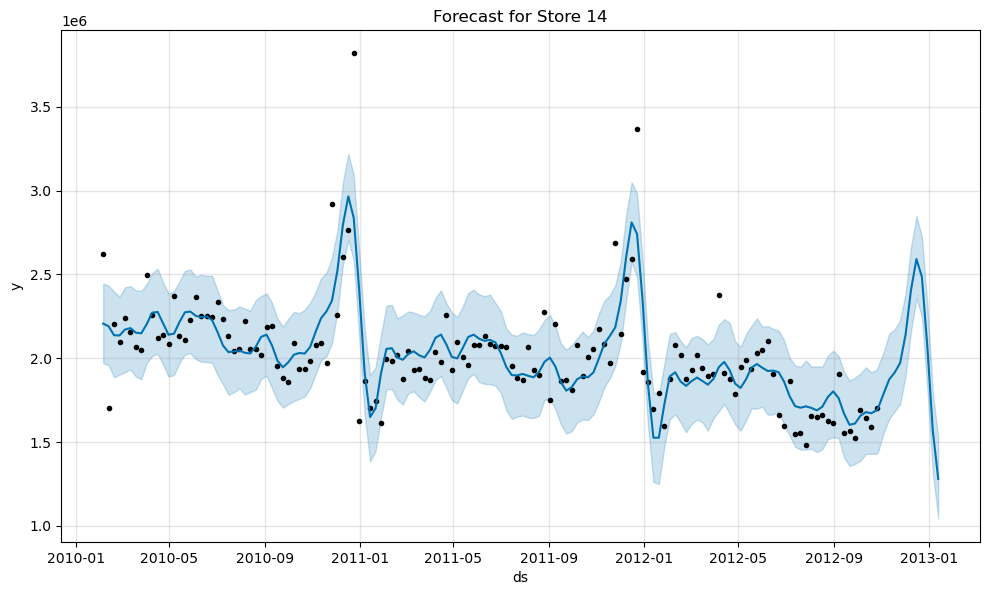

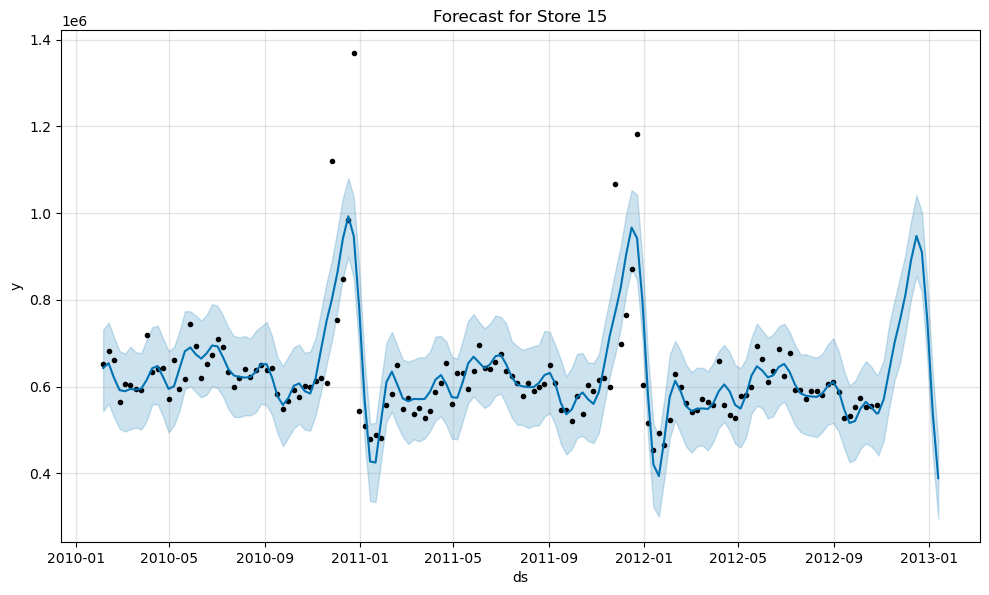

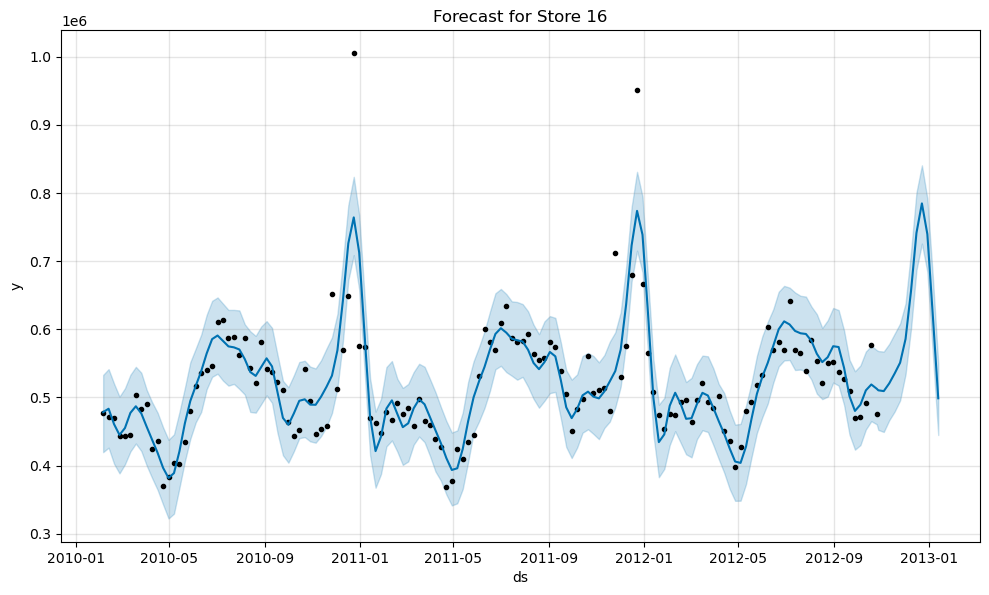

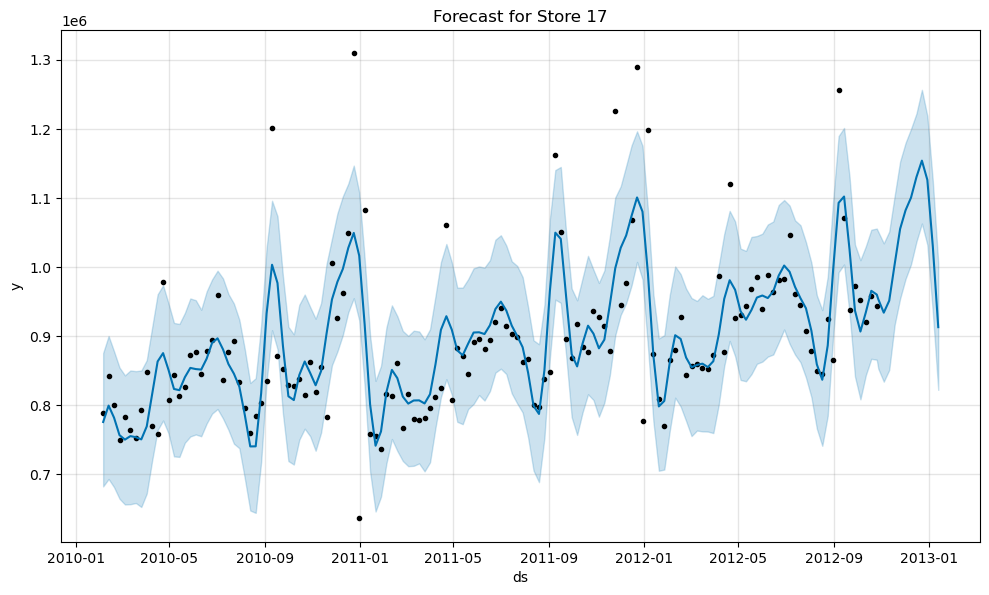

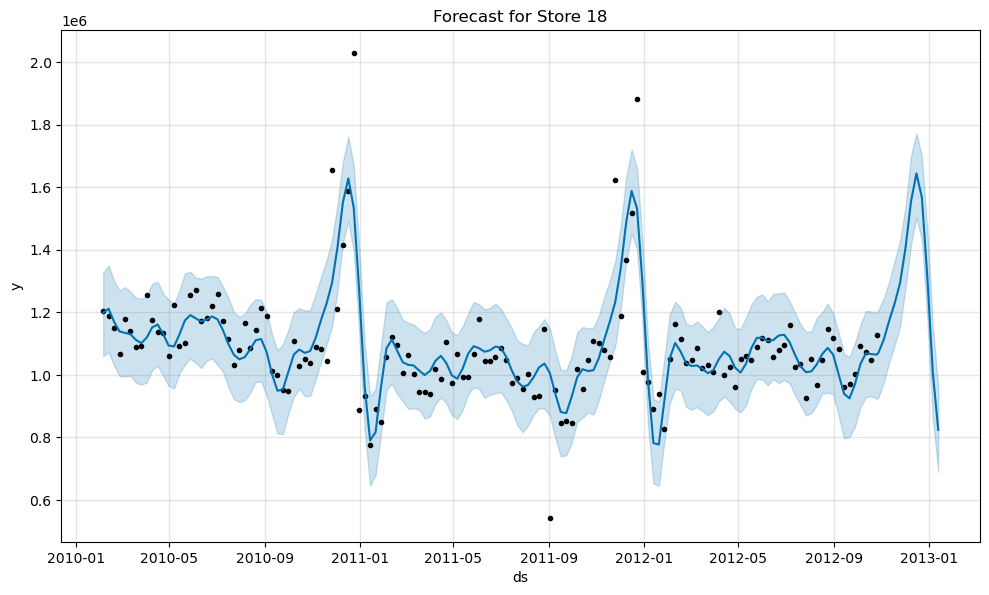

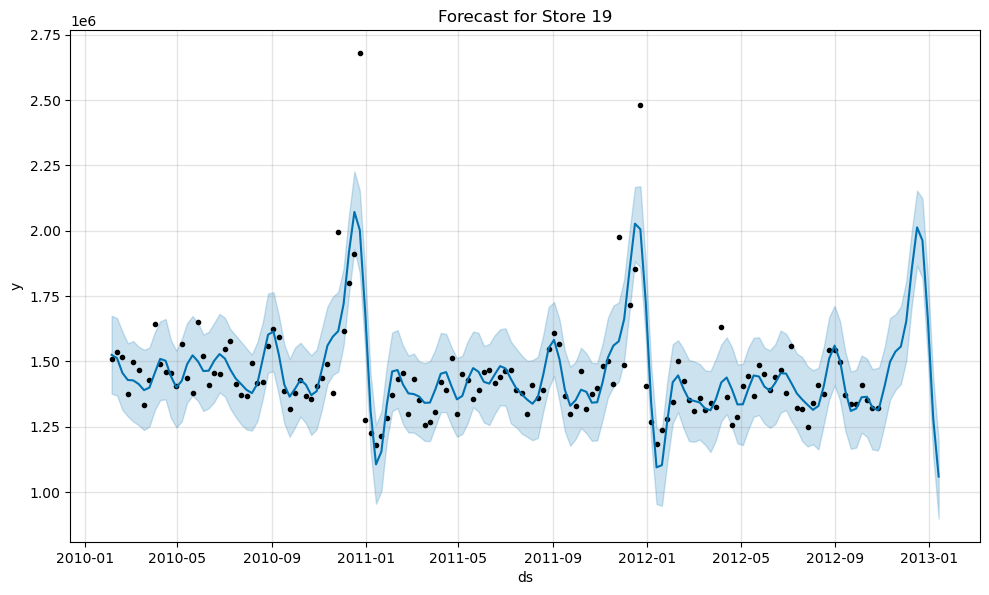

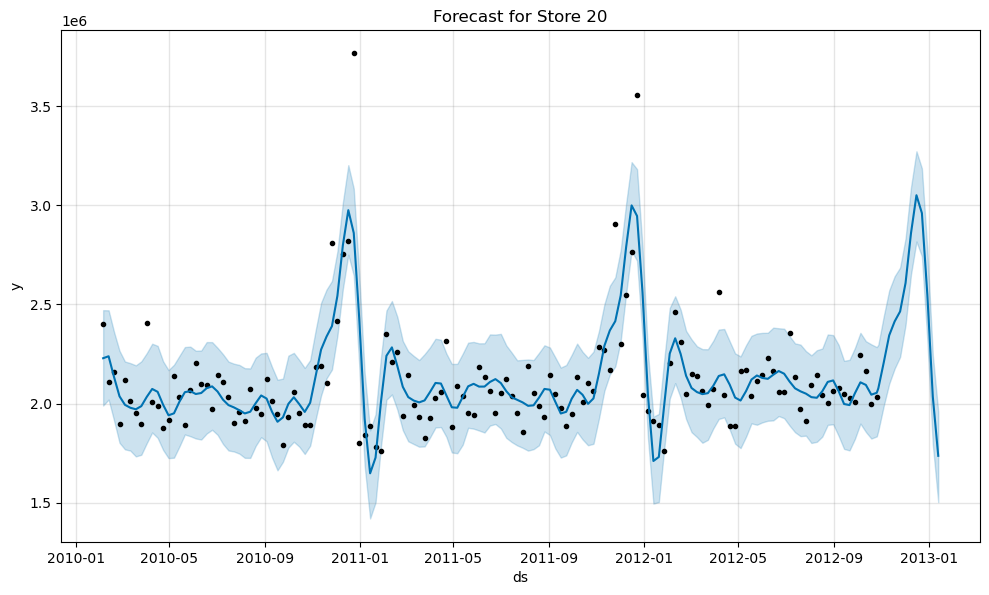

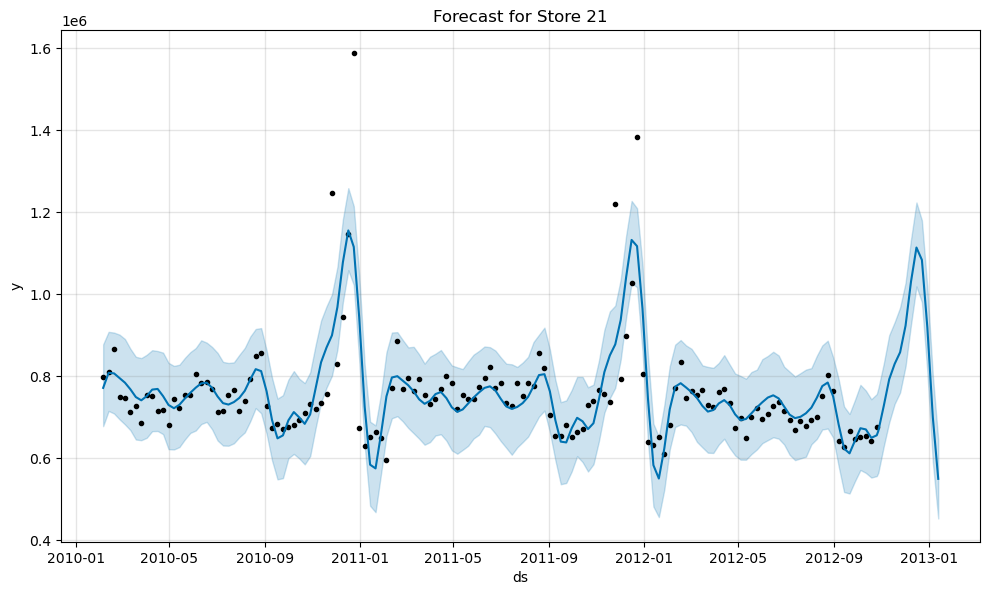

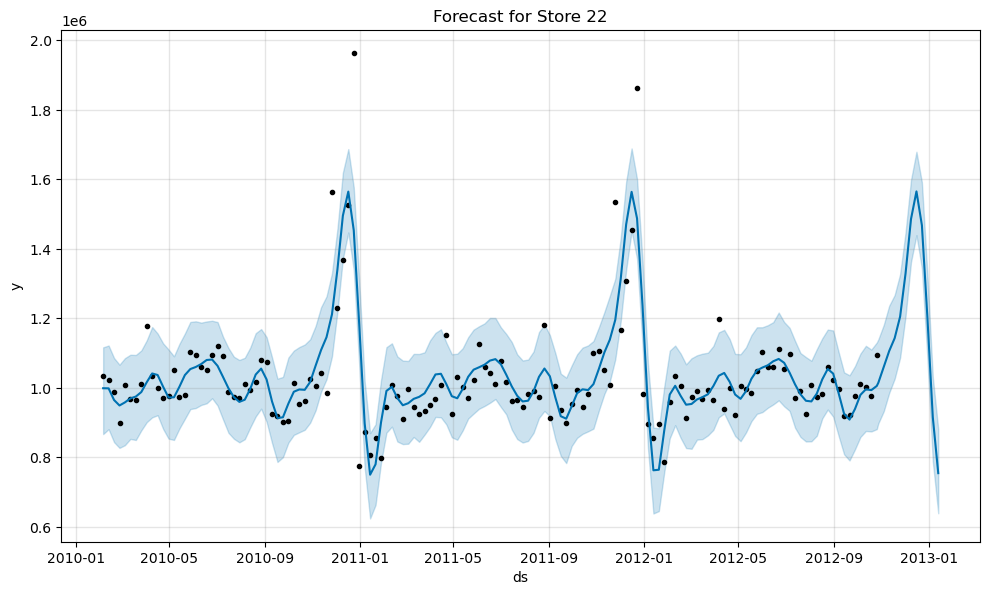

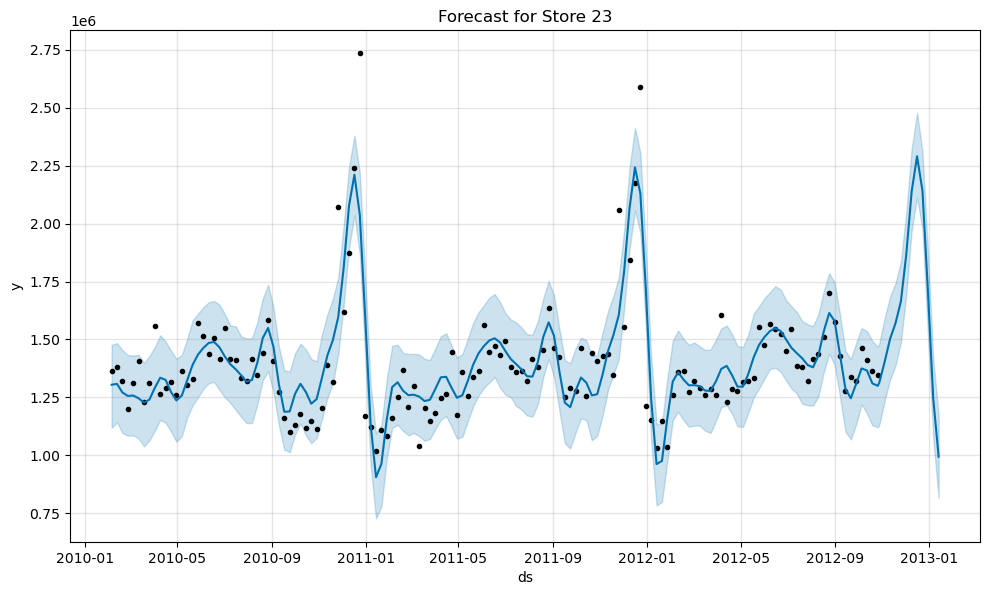

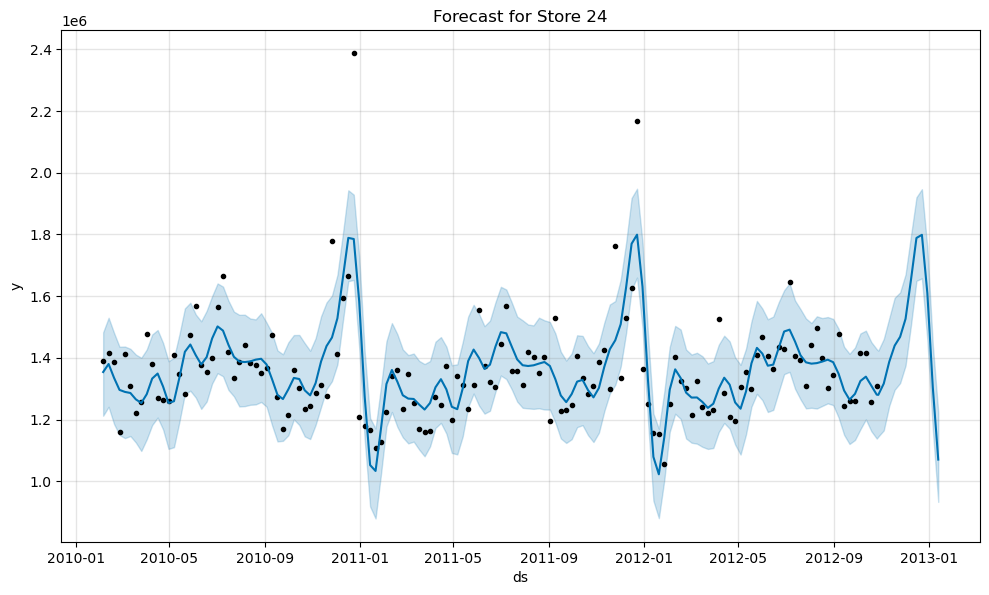

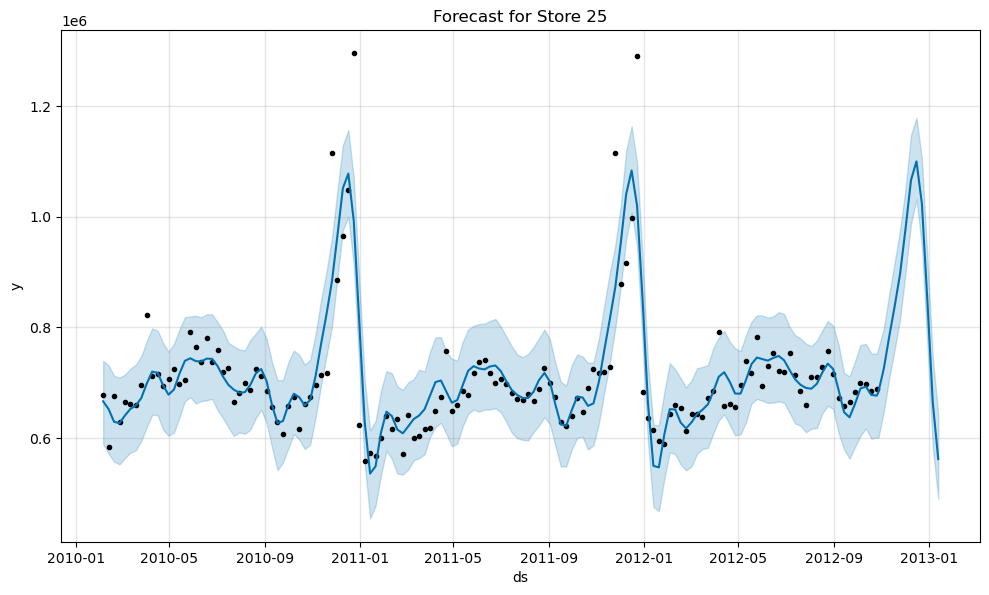

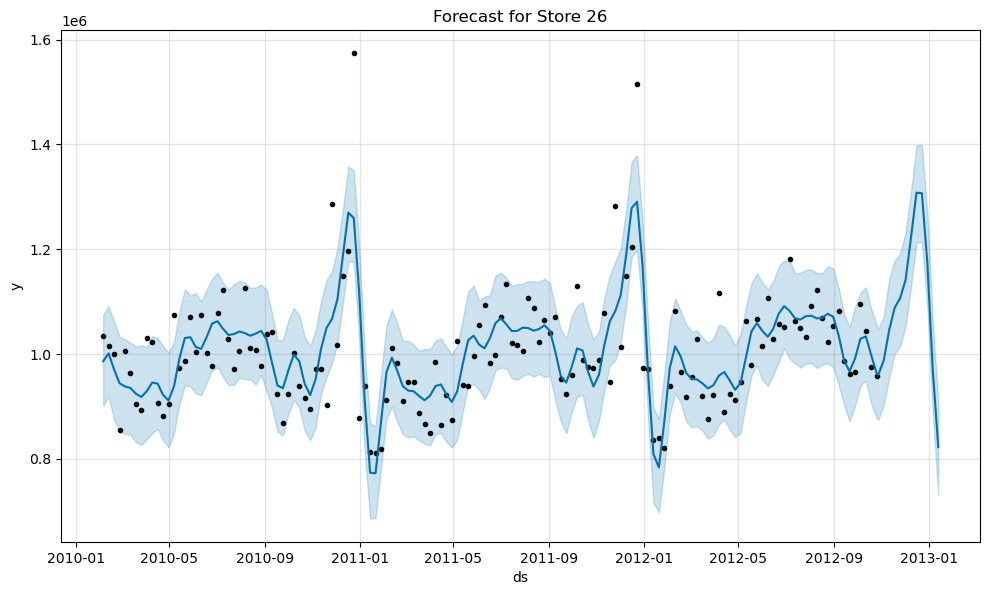

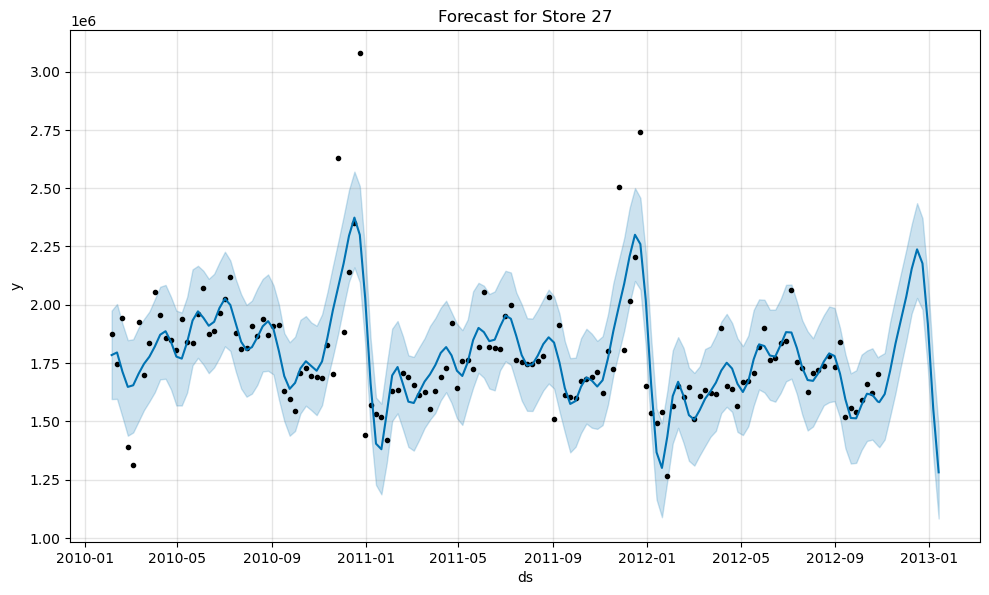

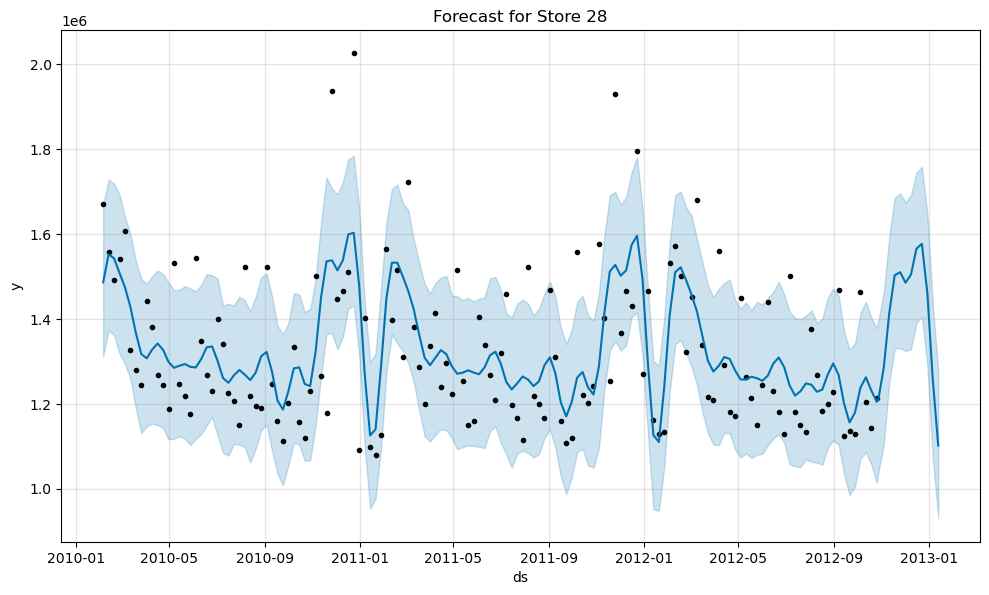

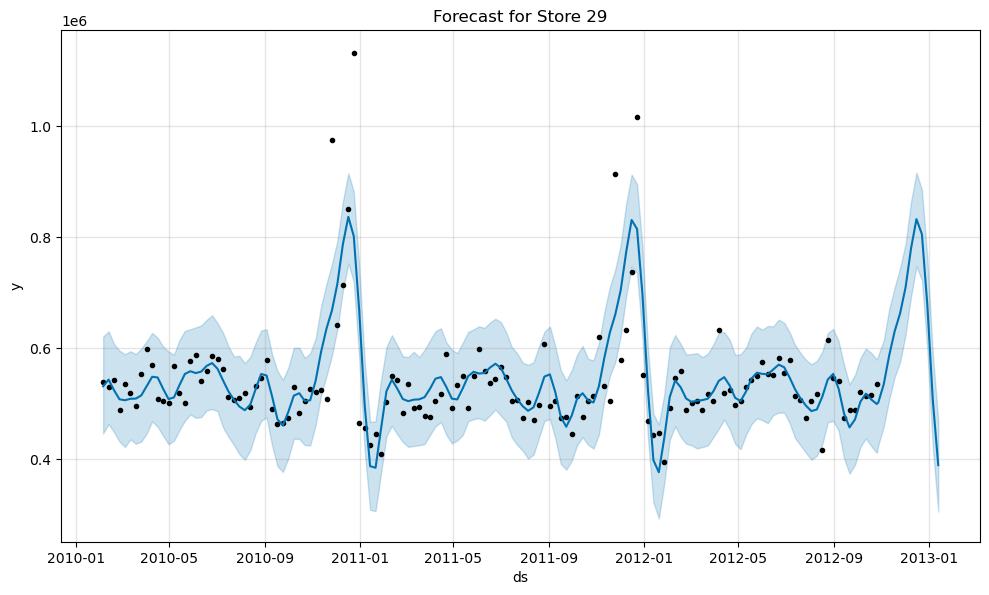

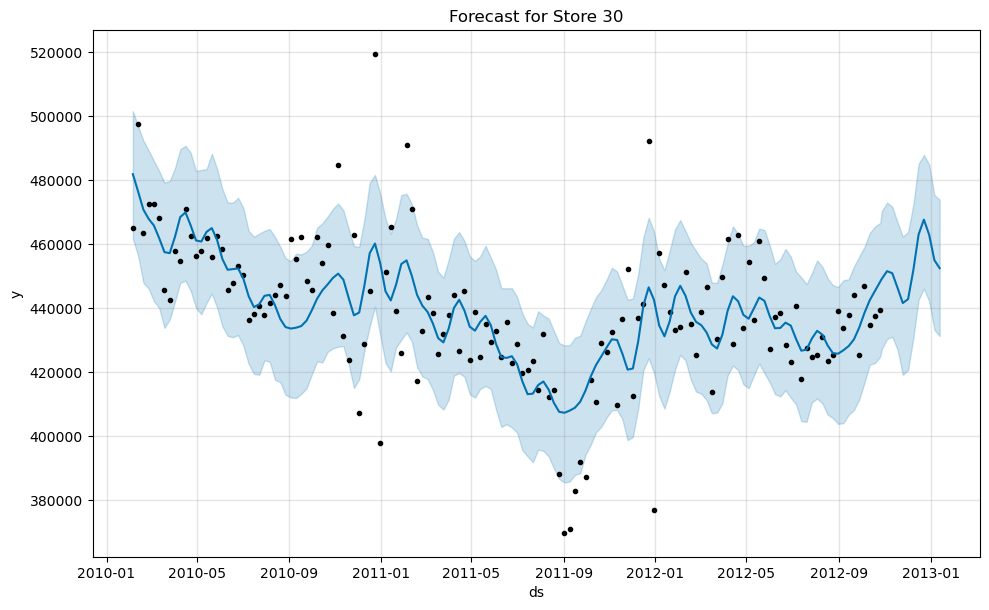

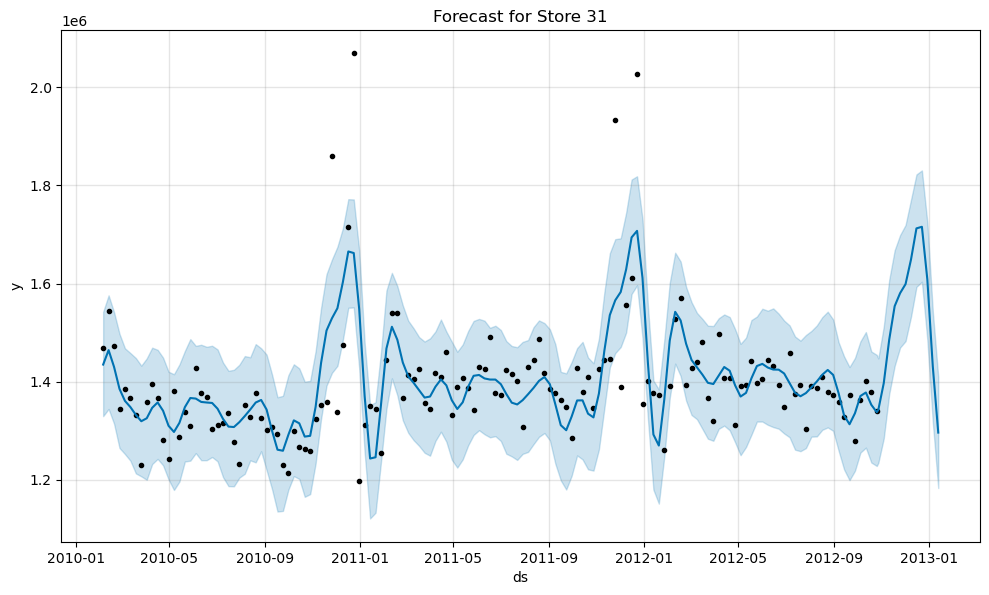

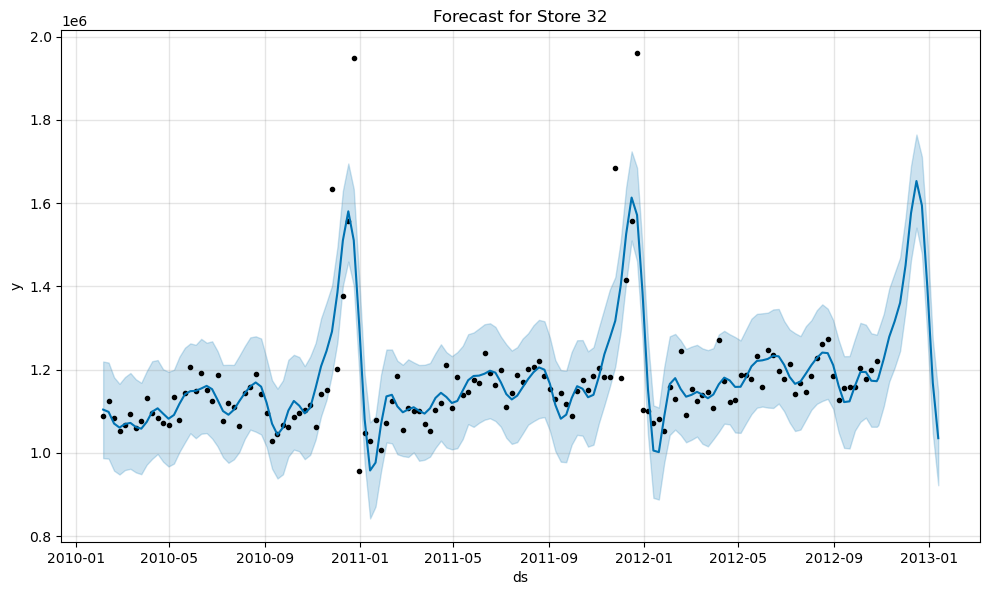

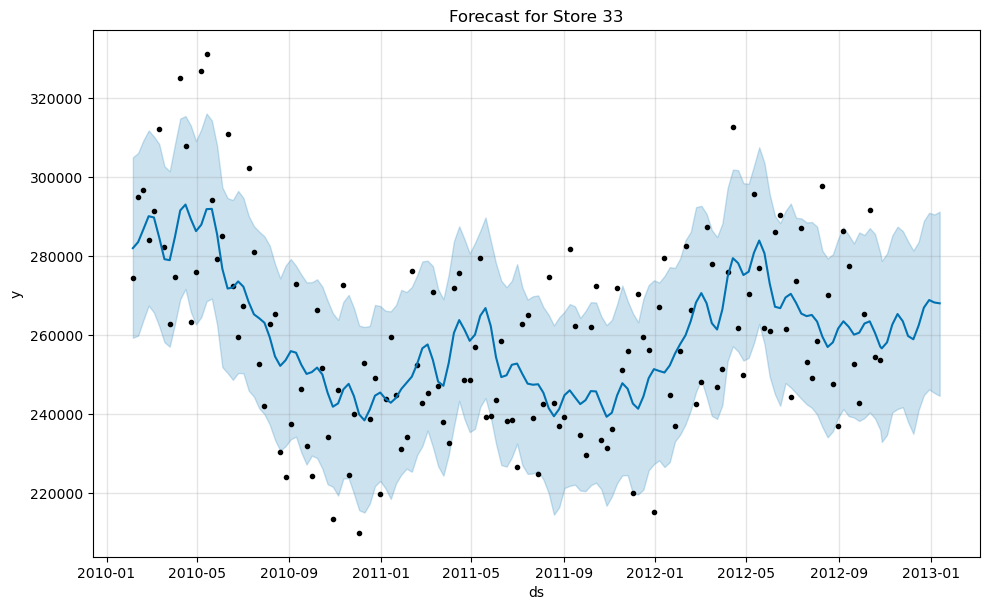

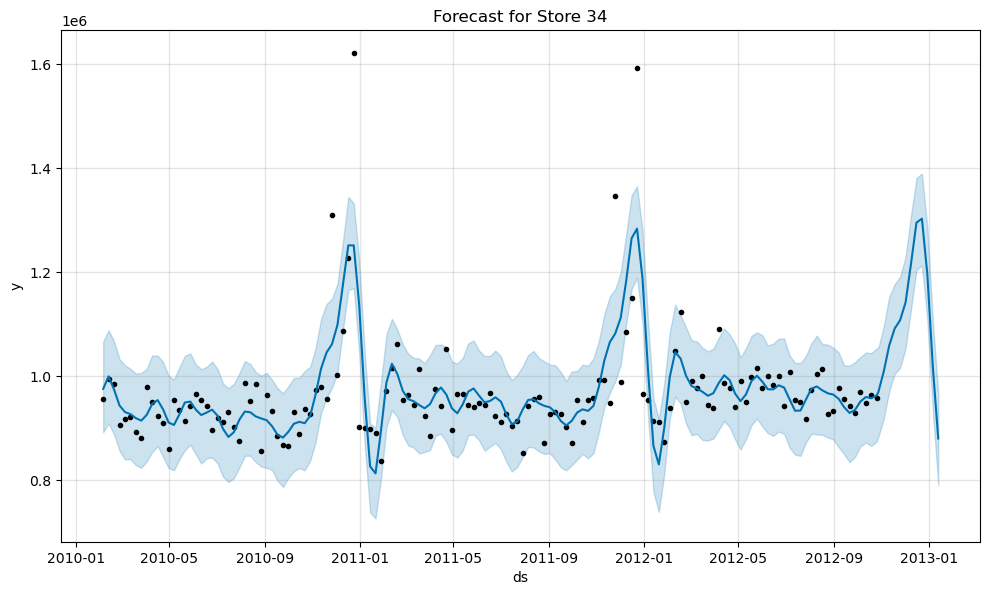

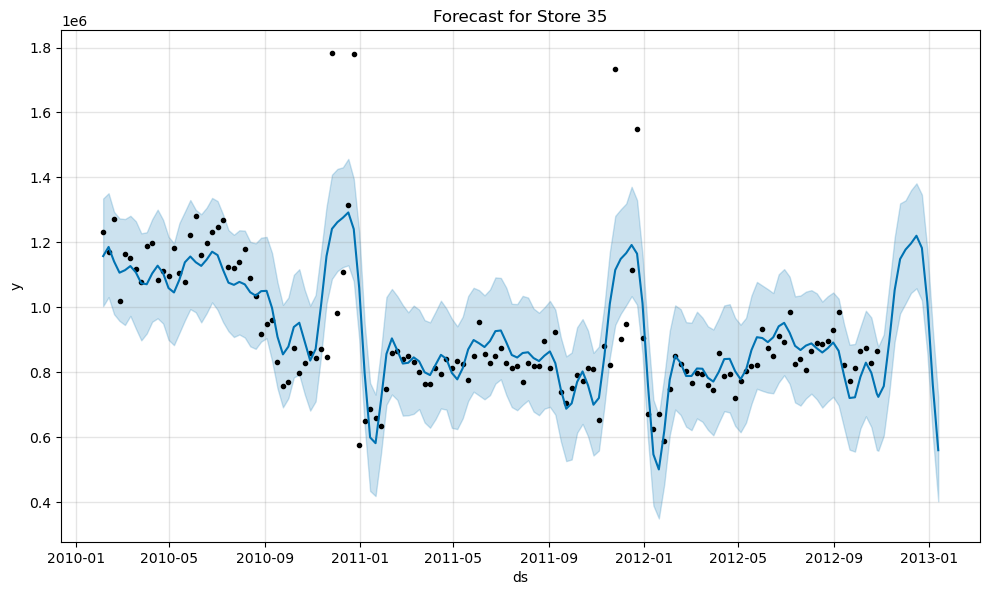

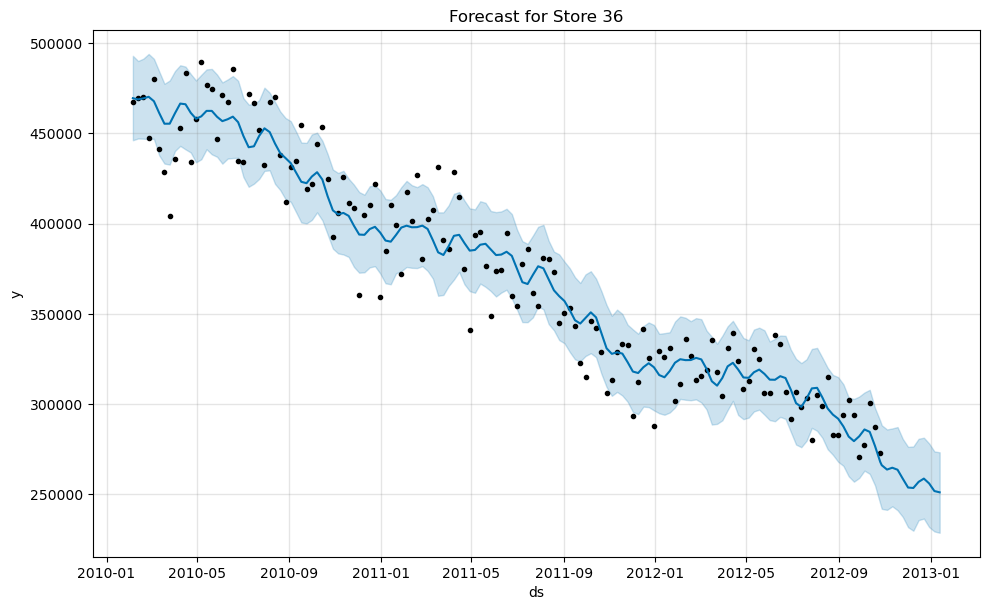

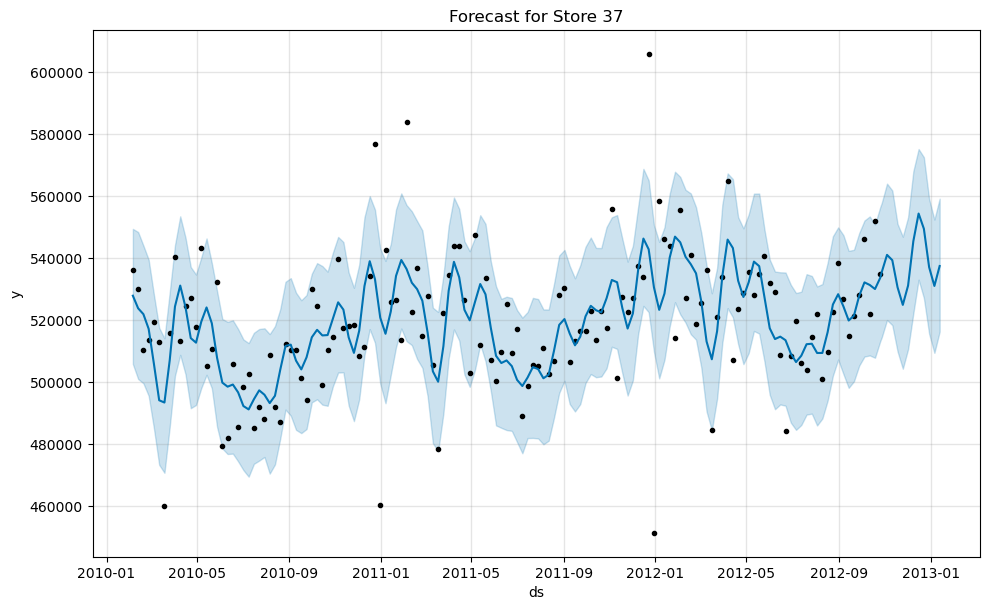

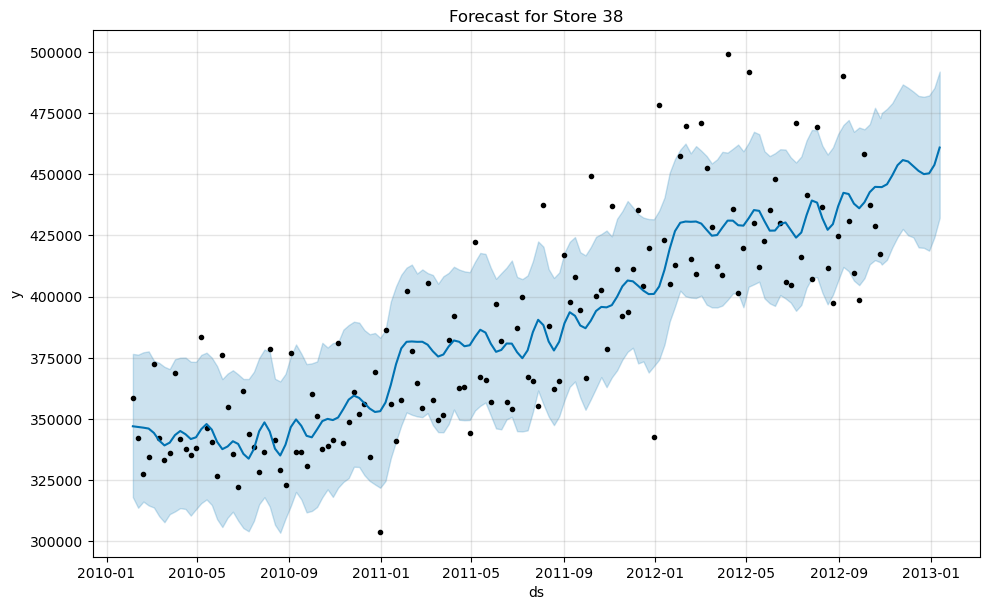

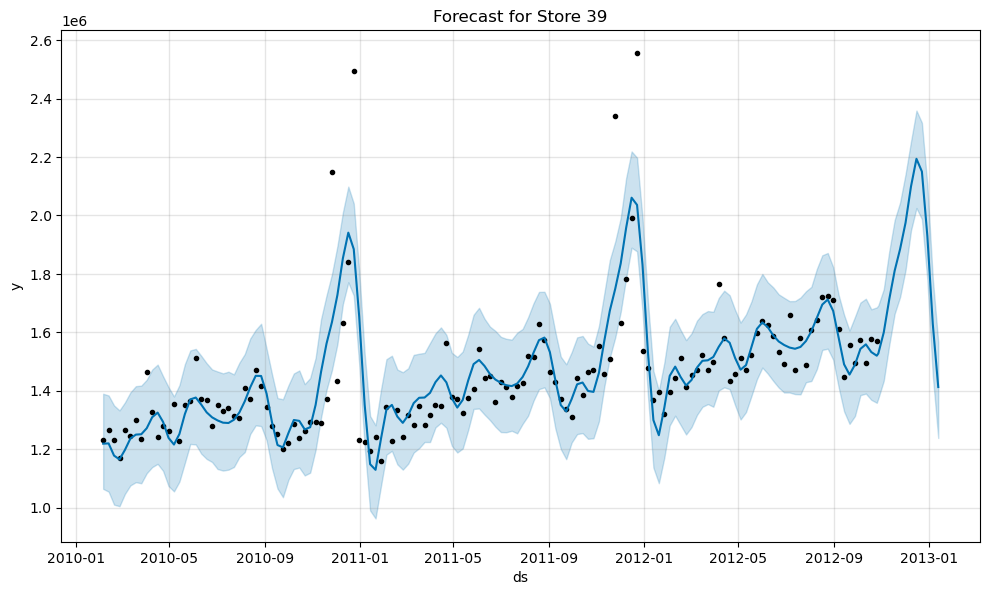

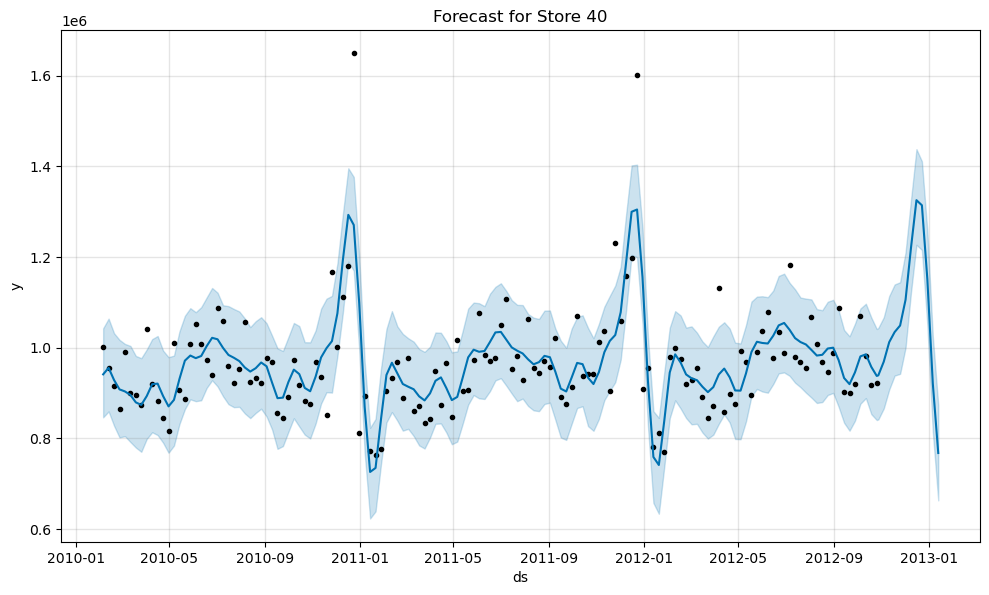

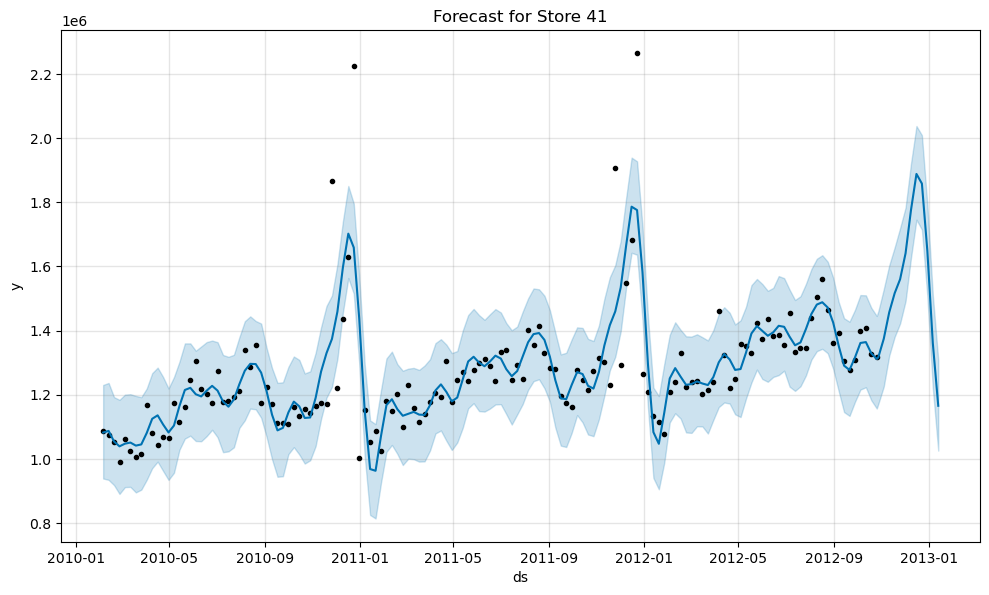

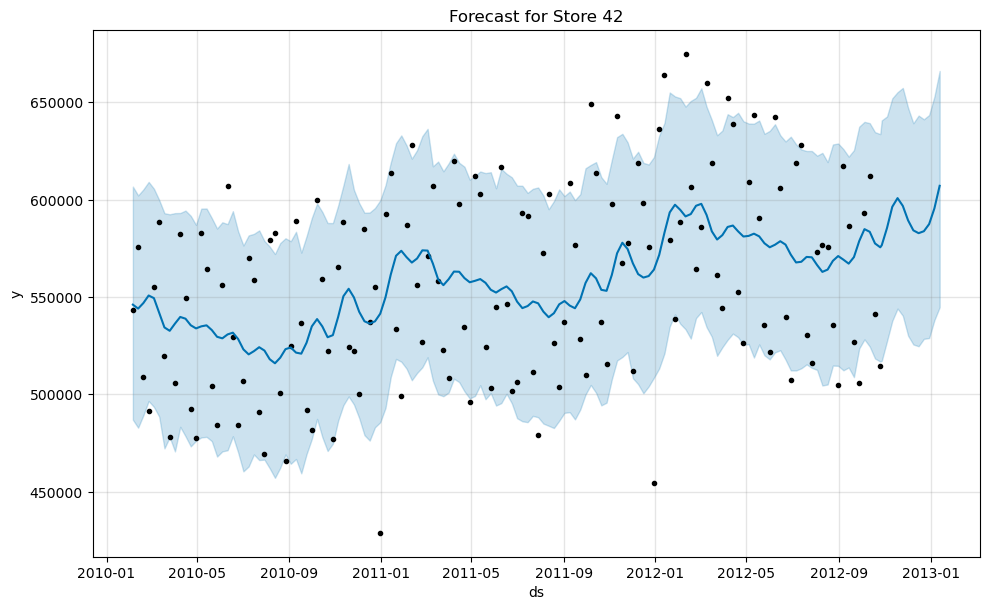

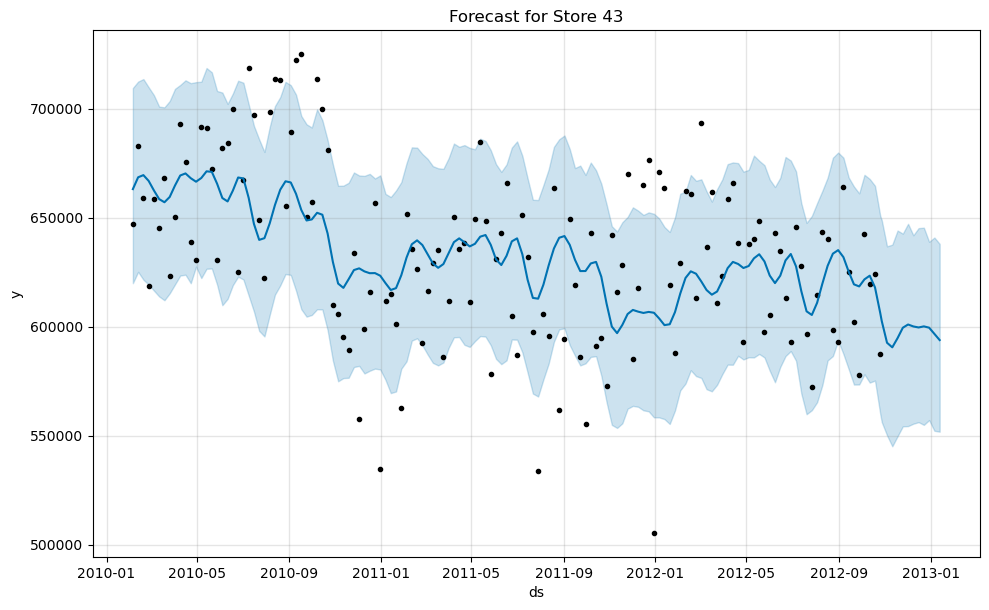

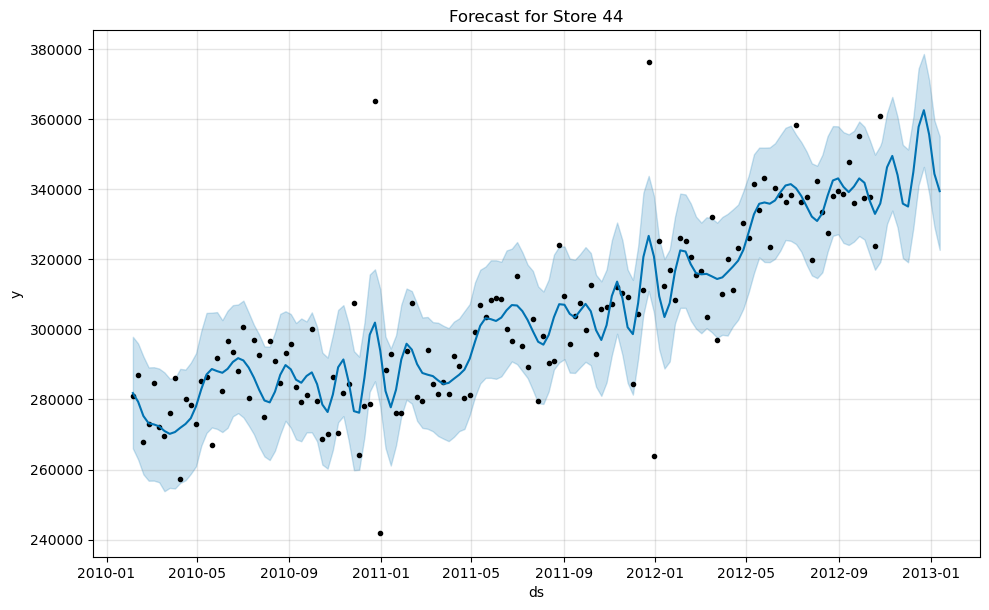

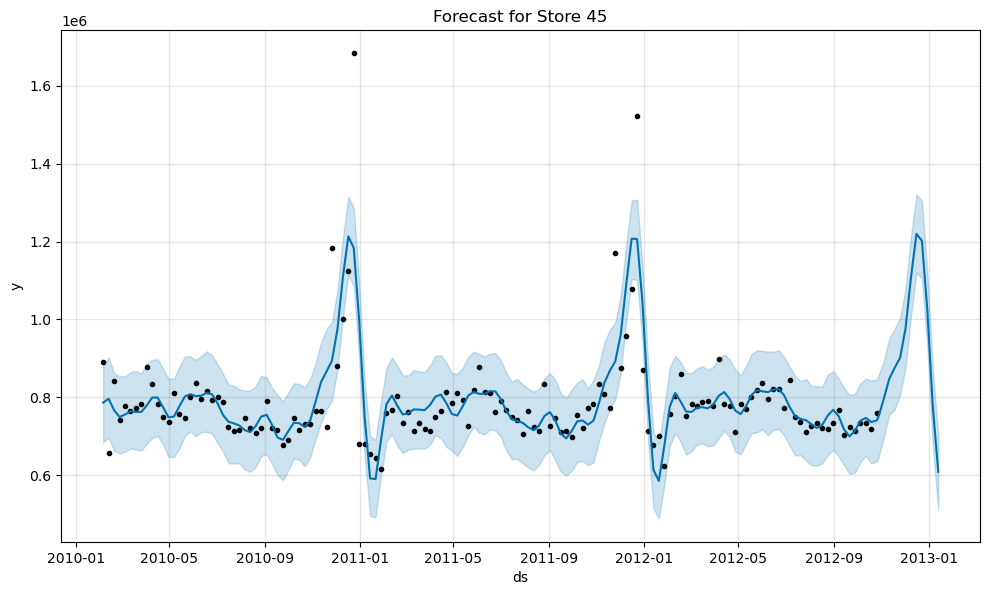

In [31]:
from prophet import Prophet
import pandas as pd
import matplotlib.pyplot as plt

store_forecasts = {}
result_df = []

for store_id in df['Store'].unique():
    store_df = df[df['Store'] == store_id][['Date', 'Weekly_Sales']].copy()
    store_df = store_df.rename(columns={"Date": "ds", "Weekly_Sales": "y"})
    store_df['ds'] = pd.to_datetime(store_df['ds'], dayfirst=True)

    if len(store_df) < 20:
        continue

    m = Prophet()
    m.fit(store_df)

    future = m.make_future_dataframe(periods=12, freq='W')
    forecast = m.predict(future)

    forecast['Store'] = store_id
    result_df.append(forecast)
    store_forecasts[store_id] = forecast

    # Optional visualization
    m.plot(forecast)
    plt.title(f"Forecast for Store {store_id}")
    plt.show()

# Save combined forecast
all_store_forecasts = pd.concat(result_df)
all_store_forecasts.to_csv("/Users/vibhutihardoneeya/Downloads/store_level_forecasts.csv", index=False)



In [27]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error, r2_score

# ✅ Step 1: Select relevant features
features = ['Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'Holiday_Flag']
X = df[features]
y = df['Weekly_Sales']

# ✅ Step 2: Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ✅ Step 3: Train Random Forest model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# ✅ Step 4: Predict and evaluate
y_pred = model.predict(X_test)

rmse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R² Score: {r2:.4f}")



Root Mean Squared Error (RMSE): 535710.51
R² Score: 0.1092


In [28]:
import joblib
joblib.dump(model, "rf_sales_model.pkl")


['rf_sales_model.pkl']

In [30]:
import os
os.getcwd()


'/Users/vibhutihardoneeya'

In [32]:
all_store_forecasts.to_excel("Walmart_Sales_Report.xlsx", index=False)


In [34]:
!pip install reportlab


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 1.3 MB/s eta 0:00:00a 0:00:01


In [36]:
from reportlab.pdfgen import canvas

c = canvas.Canvas("/Users/vibhutihardoneeya/Downloads/Sales_Forecast_Summary.pdf")

c.drawString(100, 800, "Walmart Sales Forecast Summary Report")
c.drawString(100, 780, f"Number of Stores Forecasted: {df['Store'].nunique()}")
c.drawString(100, 760, f"ML RMSE: {rmse:.2f}, R²: {r2:.2f}")
c.save()
